# Website Visitors Forecast using Facebook Prophet

### Objective
Use Prophet to forecast the unique visitor amount of a website in Europe. 
Having insights on the current data and into the future help us and our clients adjust in advance.

*  FbProphet:

Fbprophet is a open source library for time series forecasting that was developed by Facebook. It is built on top of the Python library pandas and is designed to make it easy to incorporate historical data and make forecasts for future time periods.

fbprophet uses a decomposable time series model with three main components: trend, seasonality, and holidays. The trend component models the underlying growth or decay in the data over time, while the seasonality component models repeating patterns that occur at a fixed frequency (e.g. daily, weekly, monthly). The holidays component allows the model to account for effects that occur at specific times (e.g. Christmas sales).

fbprophet includes a number of convenient functions for working with time series data, such as automatic generation of plots and summary statistics, and support for missing data and outliers. It also includes functions for tuning the model's hyperparameters and for evaluating the model's performance.

fbprophet is well-suited for a wide range of time series forecasting tasks, including business forecasting, economic forecasting, and forecasting of other types of data with seasonal patterns. It is particularly useful for cases where there is a need to make forecasts for a large number of related time series, such as forecasting demand for a product in multiple regions.


### Data Description

|Column | Description
|--------|--------|
year |Year to which the data belongs
datepart| Date on which unique visitors surfed the website
Country | Country of the users
unique_visitors |Count of unique visitors who visted on the given date

### Installing prophet and importing necessary Libraries

In [220]:
#%pip install prophet

In [221]:
#%pip install optuna

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet
import optuna 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [223]:
df = pd.read_csv("D:\Data Science\Jupyter Notebook\Intellipaat\data_fbprophet.csv")
df.head()

,year,datepart,Country,unique_visitors
0,2019,2019-01-05T00:00:00Z,Germany,359
1,2019,2019-01-05T00:00:00Z,Germany,4608
2,2019,2019-01-05T00:00:00Z,France,13747
3,2019,2019-01-05T00:00:00Z,France,295
4,2019,2019-01-05T00:00:00Z,Australia,124


In [224]:
df.shape

(72002, 4)

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72002 entries, 0 to 72001
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year             72002 non-null  int64 
 1   datepart         72002 non-null  object
 2   Country          72002 non-null  object
 3   unique_visitors  72002 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [226]:
#converting date into datetime format
df['datepart']= pd.to_datetime(df['datepart'], dayfirst=True).dt.date

In [227]:
df.isnull().sum()

year               0
datepart           0
Country            0
unique_visitors    0
dtype: int64

In [228]:
df['Country'].value_counts()

Australia    24935
Germany      23563
France       23504
Name: Country, dtype: int64

In [229]:
#we will only focus Germany for this particular forcasting model
df= df[df['Country']=="Germany"]

In [230]:
df.dtypes

year                int64
datepart           object
Country            object
unique_visitors     int64
dtype: object

In [231]:
df.rename(columns={'datepart':'date'},inplace=True)
df.head()

,year,date,Country,unique_visitors
0,2019,2019-01-05,Germany,359
1,2019,2019-01-05,Germany,4608
6,2019,2019-01-05,Germany,273
7,2019,2019-01-05,Germany,3021
12,2019,2019-01-05,Germany,72


In [232]:
df1= df.groupby('date').agg(np.sum)
df1=df1.reset_index()
df1.head()

,date,year,unique_visitors
0,2019-01-05,296793,371231
1,2019-01-12,294774,369543
2,2019-01-19,284679,381461
3,2019-01-26,292755,366196
4,2019-02-02,282660,356552


In [233]:
df1=df1.drop(columns=['year'])
df1.head()

,date,unique_visitors
0,2019-01-05,371231
1,2019-01-12,369543
2,2019-01-19,381461
3,2019-01-26,366196
4,2019-02-02,356552


In [234]:
#'y' is the target value to be forecast, 'ds' is the date. They are two essential elements for the Prophet model.
df1.columns = ['ds','y']
df1=df1[['y','ds']]
df1.head()

,y,ds
0,371231,2019-01-05
1,369543,2019-01-12
2,381461,2019-01-19
3,366196,2019-01-26
4,356552,2019-02-02


In [235]:
df1.shape

(161, 2)

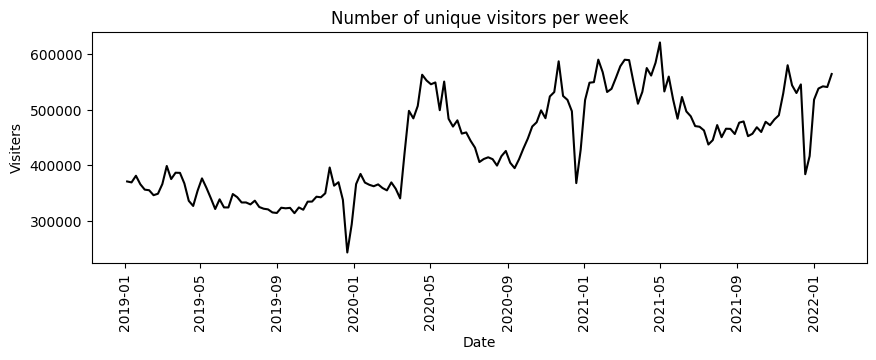

In [236]:
plt.figure(figsize=(10,3))
sns.lineplot(data=df1,x='ds',y='y',color='black')
plt.xlabel('Date')
plt.ylabel('Visiters')
plt.title('Number of unique visitors per week')
plt.xticks(rotation=90)
plt.show()

Inference: The website visitors increased along with the time. However, there is a sudden drop and rise in the week of  the New Year.

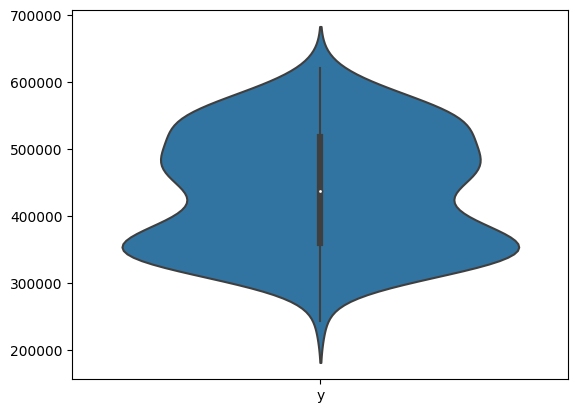

In [237]:
sns.violinplot(df1)
plt.show()

Inference: There are no outliers in our data.

In [238]:
"""#using standard deviation and mean in the formula for empirical rule, we can remove the possible outliers
SD=np.std(df1.y)
mean=np.mean(df1.y)
upper= mean + 3* SD 
lower= mean - 3* SD
#datapoints from values greater than lower and smaller than upper comprises of 95.4%
df2= df1[(df1.y>=lower) & (df1.y<=upper)]"""

'#using standard deviation and mean in the formula for empirical rule, we can remove the possible outliers\nSD=np.std(df1.y)\nmean=np.mean(df1.y)\nupper= mean + 3* SD \nlower= mean - 3* SD\n#datapoints from values greater than lower and smaller than upper comprises of 95.4%\ndf2= df1[(df1.y>=lower) & (df1.y<=upper)]'

## Simple Forecasting using Prophet with default Parameters

In [239]:
m= Prophet(interval_width=0.95,weekly_seasonality=False, daily_seasonality= False)
m.add_country_holidays(country_name='DE')
m.fit(df1)

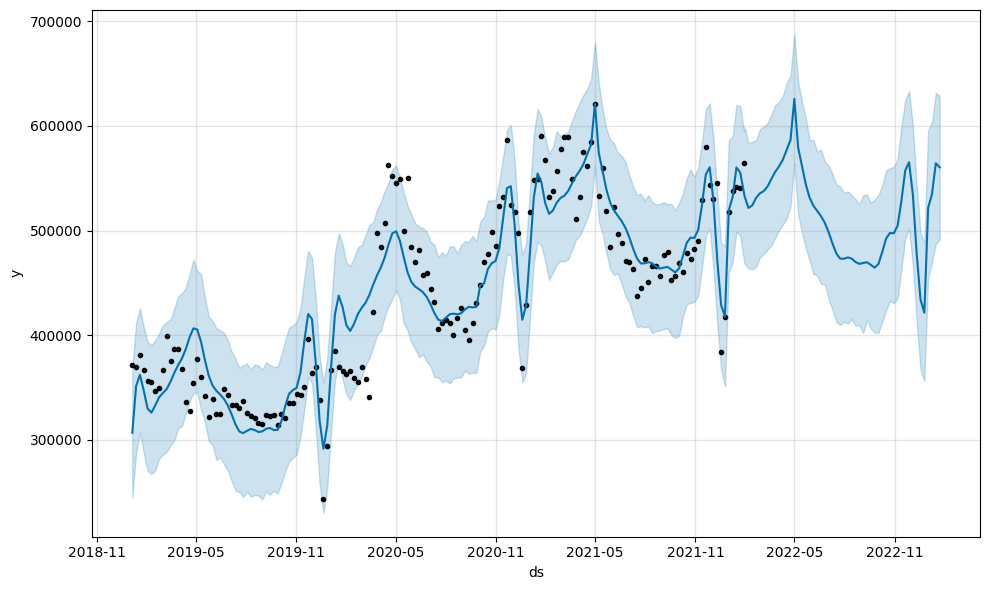

In [240]:
future_df= m.make_future_dataframe(periods=52, freq='W')
forecast= m.predict(future_df)
plot_forecast= m.plot(forecast)

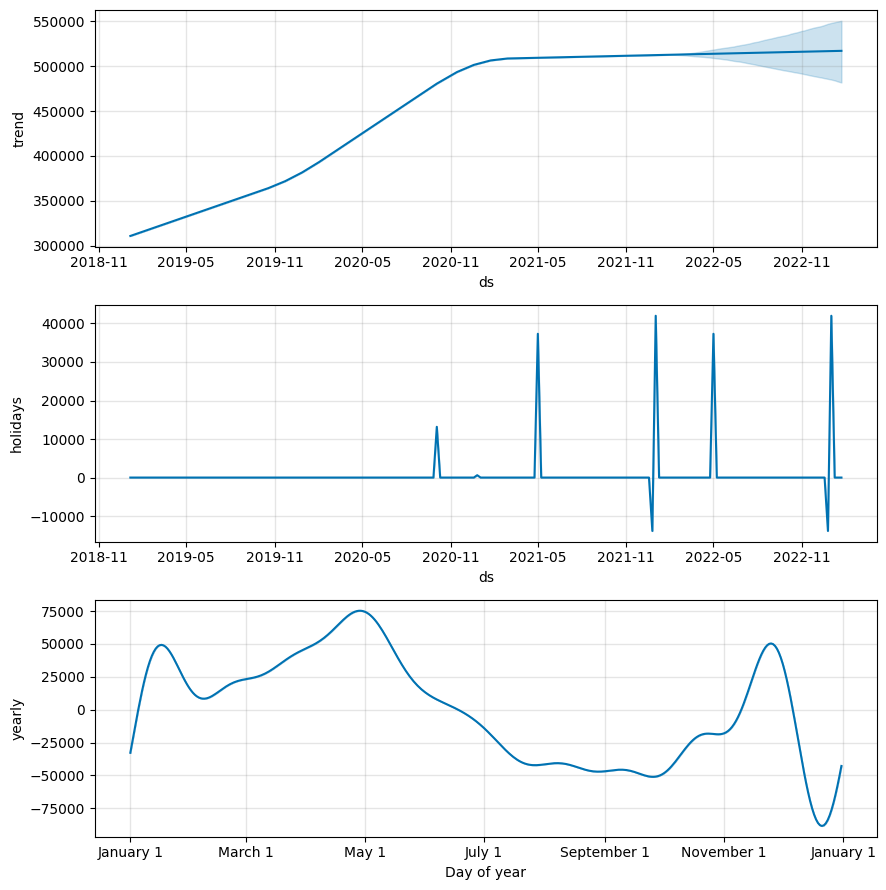

In [241]:
components= m.plot_components(forecast)

Inference: The component plot shows an upward trend in visitor count, with holidays having an impact. Christmas appears to be the biggest challenge, but the bank holidays in January and May provide a significant boost to the website. This makes sense as the website primarily sells products unrelated to Christmas.

## Forecasting with Modal Assessment

### Finding Error Function

*  Root Mean Squared Error

Root Mean Squared Error (RMSE) is a commonly used measure of the difference between predicted and actual values in a regression problem. It is the square root of the average of the squared differences between the predicted and actual values. RMSE represents the standard deviation of the differences and is expressed in the same units as the target variable. A smaller RMSE value indicates a better fit of the model to the data. RMSE is used to compare the accuracy of different models and to choose the best one for a particular problem.

* R squared Score

R^2 score is a metric that assesses the goodness of fit of a regression model. It is a value between 0 and 1, where 1 indicates a perfect fit and 0 indicates a poor fit. R^2 score is calculated as the ratio of the explained variance of the predictions to the total variance of the actual values. A higher R^2 score indicates a better fit of the model and a more accurate prediction of the target variable. R^2 score is commonly used to evaluate the performance of regression models and to compare the results of different models.

* Mean Absolute Error

Mean Absolute Error (MAE) is a commonly used measure of the difference between predicted and actual values in a regression problem. It is the average of the absolute differences between the predicted and actual values. MAE is expressed in the same units as the target variable and is a commonly used measure of the accuracy of a model. Unlike the Root Mean Squared Error (RMSE), which penalizes large errors more severely, the MAE gives equal weight to all errors, regardless of their magnitude. MAE is a robust measure of accuracy that is insensitive to outliers in the data.

In [242]:
def error(y_test,y_pred):
    mae=mean_absolute_error(y_test,y_pred)
    r2=r2_score(y_test,y_pred)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))

    print("Mean Absolute Error: ",mae)
    print("r2_score: ",r2)
    print("Root Mean Squared Error: ",rmse)

### Dividing data into train and test

In [243]:
x_train= df1.iloc[:-8,:]
x_test= df1.iloc[-8:,:]

In [244]:
m= Prophet(interval_width=0.95, daily_seasonality=False, weekly_seasonality=False)
m.add_country_holidays(country_name='DE') #DE is the ISO code for germany
m_fit= m.fit(x_train)
pred= m.predict(x_test)

In [245]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christi Himmelfahrt,Christi Himmelfahrt_lower,Christi Himmelfahrt_upper,Erster Mai,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-11,506434.208625,403023.255301,520478.017369,506316.663360,506503.461552,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-46649.299117,-46649.299117,-46649.299117,0.0,0.0,0.0,459784.909508
1,2021-12-18,506326.847345,359928.976711,478074.482167,505971.487059,506614.255814,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-85884.801648,-85884.801648,-85884.801648,0.0,0.0,0.0,420442.045697
2,2021-12-25,506219.486065,367078.549765,489099.011514,505615.008722,506739.371208,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-78510.792537,-78510.792537,-78510.792537,0.0,0.0,0.0,427708.693528
3,2022-01-01,506112.124785,417928.944058,535877.632600,505185.282358,506881.205631,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-30901.480420,-30901.480420,-30901.480420,0.0,0.0,0.0,475210.644365
4,2022-01-08,506004.763505,469144.533029,588700.241525,504735.251809,507147.524511,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,22142.225011,22142.225011,22142.225011,0.0,0.0,0.0,528146.988516


In [246]:
#mean of y to judge rmse and mae
x_test['y'].mean()

506278.125

In [247]:
error(x_test['y'],pred['yhat'])

Mean Absolute Error:  30224.696025592093
r2_score:  0.6055248528622135
Root Mean Squared Error:  39348.15865763959


Inference: R2 score is 0.6 means the model is not predicting very accurately.

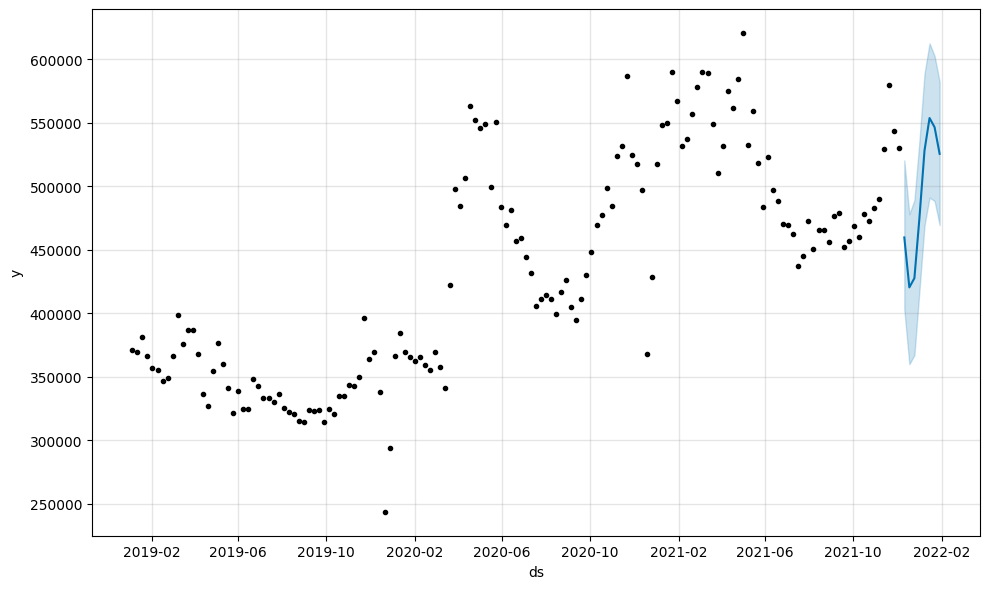

In [248]:
m.plot(pred);

### Predicting Future

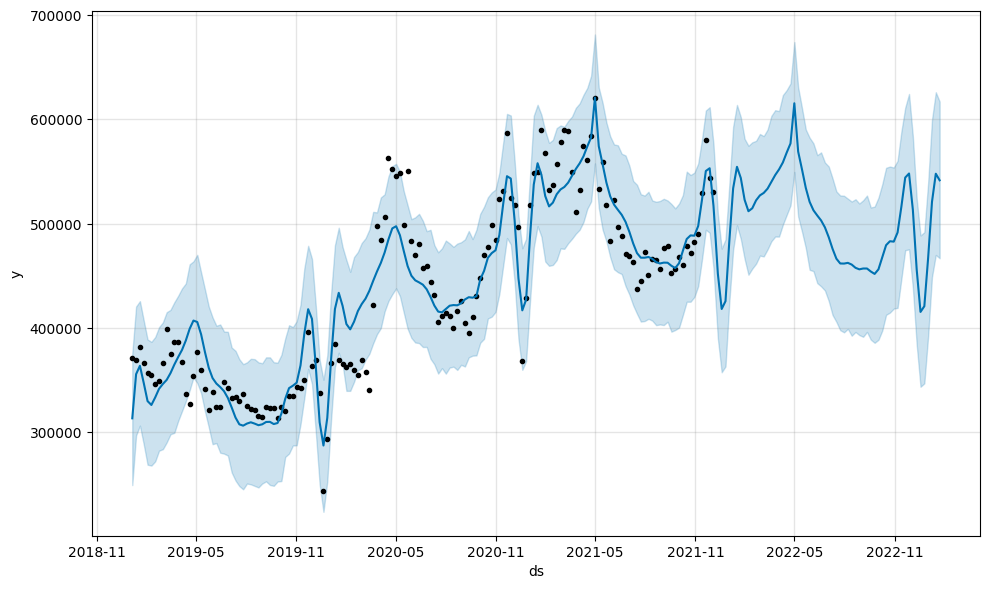

In [249]:
ft_df= m.make_future_dataframe(periods=60, freq='W')
ft_pred= m.predict(ft_df)
m.plot(ft_pred);

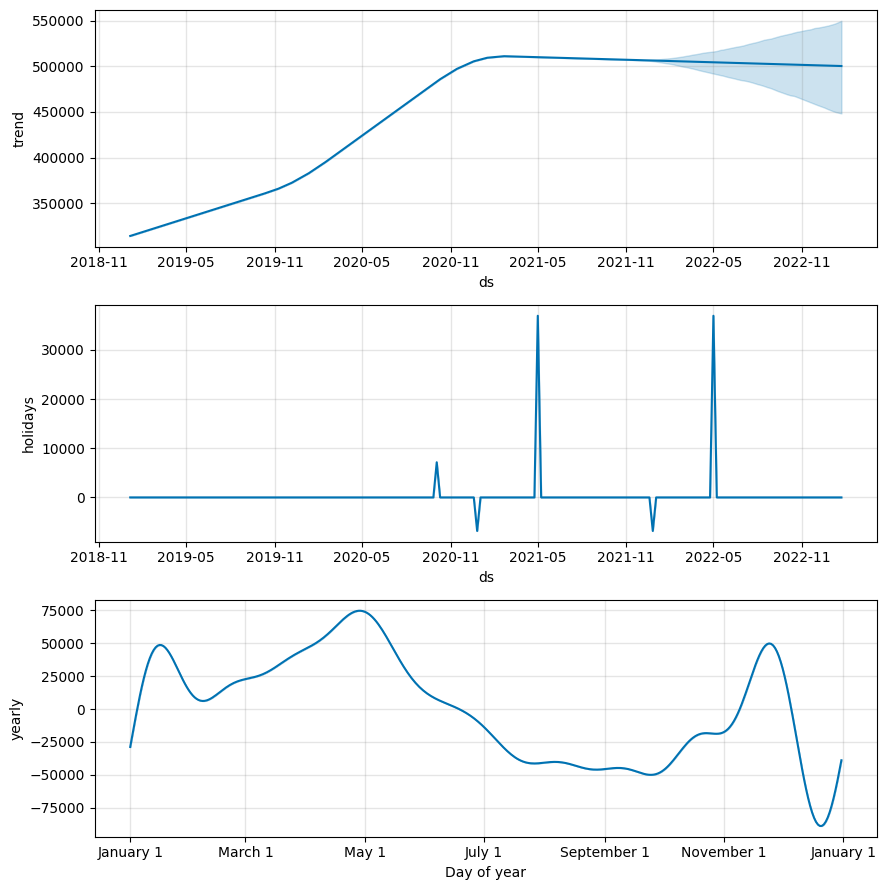

In [250]:
components= m.plot_components(ft_pred)

Inference: The component plot shows an upward trend in visitor count, with holidays having an impact. Christmas appears to be the biggest challenge, but the bank holidays in January and May provide a significant boost to the website. This makes sense as the website primarily sells products unrelated to Christmas.

## Hyperparameter Optimisation

##### Hyperparameter

In machine learning and deep learning, hyperparameters are the parameters that are set before training a model. Examples of hyperparameters include learning rate, number of hidden layers, number of neurons in a layer, and others. The optimal values of these hyperparameters can have a significant impact on the performance of the model.

##### Optuna: A hyperparameter optimization framework

Optuna is an open-source Python library for hyperparameter tuning. It provides an easy-to-use interface for conducting Bayesian optimization, grid search, and random search, among other search strategies.

Optuna provides a high-level API for defining the search space and objective function, and automates the search for the optimal hyperparameters. This makes it easier for data scientists and machine learning engineers to perform hyperparameter tuning, and helps them find the best set of hyperparameters for their model.


Optuna has modern functionalities as follows:

* Lightweight, versatile, and platform agnostic architecture

Handle a wide variety of tasks with a simple installation that has few requirements.

* Pythonic search spaces

Define search spaces using familiar Python syntax including conditionals and loops.

* Efficient optimization algorithms

Adopt state-of-the-art algorithms for sampling hyperparameters and efficiently pruning unpromising trials.

* Easy parallelization

Scale studies to tens or hundreds of workers with little or no changes to the code.

* Quick visualization

Inspect optimization histories from a variety of plotting functions.

##### Parameters
It is ideal to first understand the parametrs before tuning them. Some of the most important parameters of fbprophet include:

* growth: 

The growth parameter in Prophet is a tricky one. It can either be set to "linear" or "logistic". The suggestion is to choose "logistic" only if the data is known to saturate within the forecasting period. If not, it is recommended to keep it simple and go with "linear". Prophet will strive to move the future forecast towards the saturation point in the specified period. If the data is indeed reaching the saturation point, the user can opt for "logistic" and include the "cap" and "floor" values in the data frame.

* changepoint_prior_scale: 

The changepoint_prior_scale parameter controls the flexibility of the changepoints in the model. A higher value results in more changepoints and a more flexible model, while a lower value leads to fewer changepoints and a more rigid model.

* n_changepoints: 

The n_changepoints parameter refers to the number of changepoints, which are the points where the trend changes. By default, n_changepoints is set to 25. The changepoint_prior_scale controls the magnitude of the change. If the trend changes are overfitting, the user can increase it. If the trend changes are underfitting, the user can decrease it. The default value for changepoint_prior_scale is 0.05. Usually, it is not advised to tune n_changepoints.


* changepoint_range

The changepoint_range parameter determines how much data will be taken into consideration when setting changepoints. The default value is 0.8, meaning changepoints are only inferred for the first 80% of the time series to allow room for projecting the trend forward and avoid overfitting fluctuations at the end of the time series.

* seasonality_mode

The seasonality_mode parameter specifies the type of seasonality to model. It can either be "additive" or "multiplicative". The default value is "additive", but many business time series have multiplicative seasonality, which can be determined by looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series.

* seasonality_prior_scale: 

The seasonality_prior_scale parameter controls the flexibility of the seasonality. A higher value allows for larger fluctuations in the seasonality, while a lower value reduces the magnitude of the seasonality. The default value is 10, and a reasonable range for tuning it is [0.01, 10].

* holidays_prior_scale: 

The holidays_prior_scale parameter controls the strength of the prior belief in the holidays component of the model. A higher value results in a stronger prior belief in the holidays, while a lower value results in a weaker prior belief. The default value is 10, and a reasonable range for tuning it is [0.01, 10].

* holidays: 

The holidays parameter specifies a pandas DataFrame that contains information about the holidays to include in the model. The DataFrame should have columns for the holiday name and the date of the holiday.

* seasonality_mode: 

The seasonality_mode parameter is also used to specify the type of seasonality to model, with the options being "additive" or "multiplicative".

* yearly_seasonality

The yearly_seasonality parameter can be set to "auto", "True", or "False". By default, it is "auto". If set to "True", yearly seasonality will be turned on. The options for this parameter are ["auto", True, False]. Since the data is weekly and there is no daily or hourly data, the weekly_seasonality and daily_seasonality parameters will not be applied. A separate data frame will be created for validation purposes, taken from the primary dataset.

* interval_width: 

Specifies the width of the prediction intervals generated by the model. The prediction intervals capture the uncertainty in the predictions and are expressed as a range of values that is expected to contain the true future values of the time series with a specified level of confidence.

In [280]:
#working with copied datadrame
hp_df=df1.copy()

### Dividing data into test and train

In [281]:
#dividing train as test size as 90% and 10% respectively.
len_10per = int(hp_df.shape[0]/10)
hp_train=hp_df.iloc[:-len_10per,:]
hp_validate= hp_df.iloc[-len_10per:int(-len_10per/2),:]
hp_test= hp_df.iloc[int(-len_10per/2):,:]

In [282]:
print("Train size:",hp_train.shape)
hp_train.head()

Train size: (145, 2)


,y,ds
0,371231,2019-01-05
1,369543,2019-01-12
2,381461,2019-01-19
3,366196,2019-01-26
4,356552,2019-02-02


In [283]:
print("Test size:",hp_validate.shape)
hp_test.head()

Test size: (8, 2)


,y,ds
153,545533,2021-12-11
154,384273,2021-12-18
155,416943,2021-12-25
156,518181,2022-01-01
157,538146,2022-01-08


In [284]:
print("Test size:",hp_test.shape)
hp_test.head()

Test size: (8, 2)


,y,ds
153,545533,2021-12-11
154,384273,2021-12-18
155,416943,2021-12-25
156,518181,2022-01-01
157,538146,2022-01-08


### Optimizing using Optuna

In [296]:
#creating a function to find best parameters

def find_params(trial):
    parameters= {
        'changepoint_prior_scale':trial.suggest_float('changepoint_prior_scale',0.005,5),
        'changepoint_range':trial.suggest_float('changepoint_range',0.1,0.9),
        'seasonality_mode':trial.suggest_categorical('seasonality_mode',['multiplicative','additive']),
        'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.1,10),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',1,50),
        'holidays_prior_scale':trial.suggest_float('holidays_prior_scale',0.1,10)  
         }
    m= Prophet(**parameters, #** means unpack
               interval_width=0.95,
               weekly_seasonality=False,
               daily_seasonality=False
              )
    m.add_country_holidays(country_name='DE')
    df_fit= m.fit(hp_train)
    global count
    count += 1
    validation=m.predict(hp_validate)
    mae_for_optuna= mean_absolute_error(hp_validate['y'],validation['yhat'])
    print(f"Count : {count} MAE :----------------> {mae_for_optuna}")
    
    #we will focus on r2_score but since optuna doesn't support r2_score therefore we will first check the mae
    r2_score_for_optuna= r2_score(hp_validate['y'],validation['yhat'])
    print(f"Count : {count} r2_score :----------------> {r2_score_for_optuna}\n")
    
    return mae_for_optuna

In [297]:
#we will specify the number of trials as 150 for now. Recommended are 1000
study= optuna.create_study(direction='minimize')
count=0
study.optimize(find_params,n_trials=150)

[I 2023-02-04 17:20:49,674] A new study created in memory with name: no-name-8fabfb92-da8f-4bc0-b712-69d8f6464b51
[I 2023-02-04 17:20:51,879] Trial 0 finished with value: 20229.149840552098 and parameters: {'changepoint_prior_scale': 3.19479940292946, 'changepoint_range': 0.5470191795497409, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.7896414160834513, 'yearly_seasonality': 1, 'holidays_prior_scale': 3.2785996022979327}. Best is trial 0 with value: 20229.149840552098.


Count : 1 MAE :----------------> 20229.149840552098
Count : 1 r2_score :----------------> 0.547157512612199



[I 2023-02-04 17:20:53,441] Trial 1 finished with value: 53762.37981638867 and parameters: {'changepoint_prior_scale': 2.5161724523421287, 'changepoint_range': 0.2301626366934884, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.9631490411056274, 'yearly_seasonality': 37, 'holidays_prior_scale': 4.8172629876960675}. Best is trial 0 with value: 20229.149840552098.


Count : 2 MAE :----------------> 53762.37981638867
Count : 2 r2_score :----------------> -1.5509767587075274



[I 2023-02-04 17:20:55,243] Trial 2 finished with value: 15550.760645017755 and parameters: {'changepoint_prior_scale': 2.0133524748444547, 'changepoint_range': 0.8750584731770868, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.4873286029796855, 'yearly_seasonality': 12, 'holidays_prior_scale': 0.8112430917610871}. Best is trial 2 with value: 15550.760645017755.


Count : 3 MAE :----------------> 15550.760645017755
Count : 3 r2_score :----------------> 0.7050953183913442



[I 2023-02-04 17:20:57,202] Trial 3 finished with value: 21891.626161486027 and parameters: {'changepoint_prior_scale': 4.1889164642922205, 'changepoint_range': 0.8533056771108993, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.346493826664613, 'yearly_seasonality': 5, 'holidays_prior_scale': 5.519829572948019}. Best is trial 2 with value: 15550.760645017755.


Count : 4 MAE :----------------> 21891.626161486027
Count : 4 r2_score :----------------> 0.4522836308330197



[I 2023-02-04 17:20:58,646] Trial 4 finished with value: 63975.47863941494 and parameters: {'changepoint_prior_scale': 2.1384423022561942, 'changepoint_range': 0.302922453968179, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.29766361690772, 'yearly_seasonality': 35, 'holidays_prior_scale': 3.8824786278129513}. Best is trial 2 with value: 15550.760645017755.


Count : 5 MAE :----------------> 63975.47863941494
Count : 5 r2_score :----------------> -2.6223948789040836



[I 2023-02-04 17:21:02,970] Trial 5 finished with value: 157580.63959477536 and parameters: {'changepoint_prior_scale': 3.5251787119324205, 'changepoint_range': 0.7303876098194797, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.192235882762732, 'yearly_seasonality': 48, 'holidays_prior_scale': 1.632694817545146}. Best is trial 2 with value: 15550.760645017755.
INFO:prophet:n_changepoints greater than number of observations. Using 17.


Count : 6 MAE :----------------> 157580.63959477536
Count : 6 r2_score :----------------> -22.62205277791388



[I 2023-02-04 17:21:04,174] Trial 6 finished with value: 65194.01132581524 and parameters: {'changepoint_prior_scale': 2.7034690605304226, 'changepoint_range': 0.12594131384988333, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5067768295610006, 'yearly_seasonality': 38, 'holidays_prior_scale': 2.4801098127600847}. Best is trial 2 with value: 15550.760645017755.


Count : 7 MAE :----------------> 65194.01132581524
Count : 7 r2_score :----------------> -2.647422817544936



[I 2023-02-04 17:21:07,019] Trial 7 finished with value: 55226.08087556371 and parameters: {'changepoint_prior_scale': 1.32715694524051, 'changepoint_range': 0.5756234581297571, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.810501160116818, 'yearly_seasonality': 37, 'holidays_prior_scale': 7.778217939269196}. Best is trial 2 with value: 15550.760645017755.


Count : 8 MAE :----------------> 55226.08087556371
Count : 8 r2_score :----------------> -1.6439780865214875



[I 2023-02-04 17:21:09,762] Trial 8 finished with value: 20892.7474011323 and parameters: {'changepoint_prior_scale': 1.1936133027205549, 'changepoint_range': 0.832801452336635, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.1872801659597867, 'yearly_seasonality': 33, 'holidays_prior_scale': 5.6140137759161215}. Best is trial 2 with value: 15550.760645017755.


Count : 9 MAE :----------------> 20892.7474011323
Count : 9 r2_score :----------------> 0.48463653512123783



[I 2023-02-04 17:21:11,540] Trial 9 finished with value: 80431.92575316393 and parameters: {'changepoint_prior_scale': 2.4043581334536626, 'changepoint_range': 0.2496444203676733, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.918123346084974, 'yearly_seasonality': 46, 'holidays_prior_scale': 1.3173920920800055}. Best is trial 2 with value: 15550.760645017755.


Count : 10 MAE :----------------> 80431.92575316393
Count : 10 r2_score :----------------> -4.522225499394809



[I 2023-02-04 17:21:12,719] Trial 10 finished with value: 12538.479090712957 and parameters: {'changepoint_prior_scale': 0.1090811599478525, 'changepoint_range': 0.6605612588580481, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.567313227454912, 'yearly_seasonality': 15, 'holidays_prior_scale': 0.3359930448753842}. Best is trial 10 with value: 12538.479090712957.


Count : 11 MAE :----------------> 12538.479090712957
Count : 11 r2_score :----------------> 0.7645448677147504



[I 2023-02-04 17:21:13,836] Trial 11 finished with value: 15656.772556089214 and parameters: {'changepoint_prior_scale': 0.10838969895392564, 'changepoint_range': 0.7122733963499241, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.387611752172401, 'yearly_seasonality': 15, 'holidays_prior_scale': 0.16410483223858274}. Best is trial 10 with value: 12538.479090712957.


Count : 12 MAE :----------------> 15656.772556089214
Count : 12 r2_score :----------------> 0.586545503799901



[I 2023-02-04 17:21:15,029] Trial 12 finished with value: 21900.654740679514 and parameters: {'changepoint_prior_scale': 0.13333117774413283, 'changepoint_range': 0.8696216680437033, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.957336675558788, 'yearly_seasonality': 17, 'holidays_prior_scale': 0.18955853298635184}. Best is trial 10 with value: 12538.479090712957.


Count : 13 MAE :----------------> 21900.654740679514
Count : 13 r2_score :----------------> 0.45423888226040277



[I 2023-02-04 17:21:18,016] Trial 13 finished with value: 44330.15376490746 and parameters: {'changepoint_prior_scale': 4.832310098573512, 'changepoint_range': 0.6819721829797811, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.39892150349183875, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.7513182415815312}. Best is trial 10 with value: 12538.479090712957.


Count : 14 MAE :----------------> 44330.15376490746
Count : 14 r2_score :----------------> -1.1929920352413186



[I 2023-02-04 17:21:20,631] Trial 14 finished with value: 22690.62994574957 and parameters: {'changepoint_prior_scale': 1.0388155218912187, 'changepoint_range': 0.8972779666312536, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.9429625593218836, 'yearly_seasonality': 24, 'holidays_prior_scale': 0.13952418780338557}. Best is trial 10 with value: 12538.479090712957.


Count : 15 MAE :----------------> 22690.62994574957
Count : 15 r2_score :----------------> 0.411775968619568



[I 2023-02-04 17:21:22,593] Trial 15 finished with value: 52874.98337130466 and parameters: {'changepoint_prior_scale': 1.7891229683697132, 'changepoint_range': 0.42924977925604146, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.0542501405760487, 'yearly_seasonality': 10, 'holidays_prior_scale': 2.6864811393910673}. Best is trial 10 with value: 12538.479090712957.


Count : 16 MAE :----------------> 52874.98337130466
Count : 16 r2_score :----------------> -1.3147496981259734



[I 2023-02-04 17:21:25,432] Trial 16 finished with value: 18322.788655609613 and parameters: {'changepoint_prior_scale': 0.9160788136516052, 'changepoint_range': 0.7672980416773671, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.507392332647581, 'yearly_seasonality': 23, 'holidays_prior_scale': 1.216667991209527}. Best is trial 10 with value: 12538.479090712957.


Count : 17 MAE :----------------> 18322.788655609613
Count : 17 r2_score :----------------> 0.6867393329850611



[I 2023-02-04 17:21:26,990] Trial 17 finished with value: 31283.32088815057 and parameters: {'changepoint_prior_scale': 0.47996195859030877, 'changepoint_range': 0.6355331245063087, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.291436625491349, 'yearly_seasonality': 9, 'holidays_prior_scale': 3.532172369972729}. Best is trial 10 with value: 12538.479090712957.


Count : 18 MAE :----------------> 31283.32088815057
Count : 18 r2_score :----------------> 0.12677121588748885



[I 2023-02-04 17:21:30,422] Trial 18 finished with value: 21638.981840278306 and parameters: {'changepoint_prior_scale': 1.6943031946242608, 'changepoint_range': 0.76811071523203, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.107818190418033, 'yearly_seasonality': 29, 'holidays_prior_scale': 9.84438581045388}. Best is trial 10 with value: 12538.479090712957.


Count : 19 MAE :----------------> 21638.981840278306
Count : 19 r2_score :----------------> 0.5623174640420385



[I 2023-02-04 17:21:31,941] Trial 19 finished with value: 32213.990356599636 and parameters: {'changepoint_prior_scale': 0.39429463882874033, 'changepoint_range': 0.6404890157243034, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.7280711462481686, 'yearly_seasonality': 20, 'holidays_prior_scale': 1.0594394943603183}. Best is trial 10 with value: 12538.479090712957.


Count : 20 MAE :----------------> 32213.990356599636
Count : 20 r2_score :----------------> 0.11176047878080408



[I 2023-02-04 17:21:33,646] Trial 20 finished with value: 27138.71215294361 and parameters: {'changepoint_prior_scale': 0.7501595698005827, 'changepoint_range': 0.4808965744847489, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.106290834566027, 'yearly_seasonality': 11, 'holidays_prior_scale': 2.38288645478505}. Best is trial 10 with value: 12538.479090712957.


Count : 21 MAE :----------------> 27138.71215294361
Count : 21 r2_score :----------------> 0.3307084698388627



[I 2023-02-04 17:21:35,084] Trial 21 finished with value: 16856.01569055683 and parameters: {'changepoint_prior_scale': 0.1711497532373618, 'changepoint_range': 0.7647723776537376, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.650933085962202, 'yearly_seasonality': 14, 'holidays_prior_scale': 0.34978310609262864}. Best is trial 10 with value: 12538.479090712957.


Count : 22 MAE :----------------> 16856.01569055683
Count : 22 r2_score :----------------> 0.5108997818543572



[I 2023-02-04 17:21:36,379] Trial 22 finished with value: 47844.32987992324 and parameters: {'changepoint_prior_scale': 0.010759050683211924, 'changepoint_range': 0.7096017514738222, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.350498189927563, 'yearly_seasonality': 5, 'holidays_prior_scale': 0.7721723757649323}. Best is trial 10 with value: 12538.479090712957.


Count : 23 MAE :----------------> 47844.32987992324
Count : 23 r2_score :----------------> -1.4254453323647645



[I 2023-02-04 17:21:38,420] Trial 23 finished with value: 13340.536606740294 and parameters: {'changepoint_prior_scale': 0.5653571240474261, 'changepoint_range': 0.8100738256982907, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.8901866455608682, 'yearly_seasonality': 20, 'holidays_prior_scale': 0.10873612775352107}. Best is trial 10 with value: 12538.479090712957.


Count : 24 MAE :----------------> 13340.536606740294
Count : 24 r2_score :----------------> 0.7995509151539146



[I 2023-02-04 17:21:40,336] Trial 24 finished with value: 14438.057999028839 and parameters: {'changepoint_prior_scale': 0.6693674960235847, 'changepoint_range': 0.8205107370767856, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.9484220191123174, 'yearly_seasonality': 20, 'holidays_prior_scale': 1.6780966140045919}. Best is trial 10 with value: 12538.479090712957.


Count : 25 MAE :----------------> 14438.057999028839
Count : 25 r2_score :----------------> 0.7917431264848278



[I 2023-02-04 17:21:42,062] Trial 25 finished with value: 16925.42171771157 and parameters: {'changepoint_prior_scale': 0.6481034160879635, 'changepoint_range': 0.8096873517586998, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.7204640743426944, 'yearly_seasonality': 27, 'holidays_prior_scale': 2.0705244407477426}. Best is trial 10 with value: 12538.479090712957.


Count : 26 MAE :----------------> 16925.42171771157
Count : 26 r2_score :----------------> 0.7195877749149271



[I 2023-02-04 17:21:44,345] Trial 26 finished with value: 16218.137049904268 and parameters: {'changepoint_prior_scale': 0.6892813722040505, 'changepoint_range': 0.8076692380748246, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.062706311089009, 'yearly_seasonality': 21, 'holidays_prior_scale': 1.2838645200105}. Best is trial 10 with value: 12538.479090712957.


Count : 27 MAE :----------------> 16218.137049904268
Count : 27 r2_score :----------------> 0.754602315425354



[I 2023-02-04 17:21:46,699] Trial 27 finished with value: 22269.73899003963 and parameters: {'changepoint_prior_scale': 1.4644793284691011, 'changepoint_range': 0.6747931209003013, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.873527214132583, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.9062532679448578}. Best is trial 10 with value: 12538.479090712957.


Count : 28 MAE :----------------> 22269.73899003963
Count : 28 r2_score :----------------> 0.4478653138898038



[I 2023-02-04 17:21:48,557] Trial 28 finished with value: 21172.89162155609 and parameters: {'changepoint_prior_scale': 1.0802707256278175, 'changepoint_range': 0.8049303651088575, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.5896717645321337, 'yearly_seasonality': 30, 'holidays_prior_scale': 0.6791159856251687}. Best is trial 10 with value: 12538.479090712957.


Count : 29 MAE :----------------> 21172.89162155609
Count : 29 r2_score :----------------> 0.5450304449700027



[I 2023-02-04 17:21:49,885] Trial 29 finished with value: 39682.03308935967 and parameters: {'changepoint_prior_scale': 0.49690426782897157, 'changepoint_range': 0.5947721623995038, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 2.954268446022541, 'yearly_seasonality': 5, 'holidays_prior_scale': 2.937119304968917}. Best is trial 10 with value: 12538.479090712957.


Count : 30 MAE :----------------> 39682.03308935967
Count : 30 r2_score :----------------> -0.7187632243565636



[I 2023-02-04 17:21:51,826] Trial 30 finished with value: 13526.835211358935 and parameters: {'changepoint_prior_scale': 0.9464454689119705, 'changepoint_range': 0.7548011525825704, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.494580152200934, 'yearly_seasonality': 26, 'holidays_prior_scale': 1.9477943184333286}. Best is trial 10 with value: 12538.479090712957.


Count : 31 MAE :----------------> 13526.835211358935
Count : 31 r2_score :----------------> 0.7906570429616624



[I 2023-02-04 17:21:54,071] Trial 31 finished with value: 13515.900957802638 and parameters: {'changepoint_prior_scale': 0.8689741581793757, 'changepoint_range': 0.7541282384484699, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.50724649755765, 'yearly_seasonality': 26, 'holidays_prior_scale': 1.7686932575960839}. Best is trial 10 with value: 12538.479090712957.


Count : 32 MAE :----------------> 13515.900957802638
Count : 32 r2_score :----------------> 0.7860928185516632



[I 2023-02-04 17:21:56,343] Trial 32 finished with value: 13549.643720967098 and parameters: {'changepoint_prior_scale': 0.9330634747873806, 'changepoint_range': 0.7461141574316935, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.514535235390939, 'yearly_seasonality': 26, 'holidays_prior_scale': 0.8451043867830281}. Best is trial 10 with value: 12538.479090712957.


Count : 33 MAE :----------------> 13549.643720967098
Count : 33 r2_score :----------------> 0.7920623281843958



[I 2023-02-04 17:21:59,103] Trial 33 finished with value: 22436.661053932716 and parameters: {'changepoint_prior_scale': 1.3734214274147418, 'changepoint_range': 0.6677172743888651, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.345086740683005, 'yearly_seasonality': 31, 'holidays_prior_scale': 2.212322554351079}. Best is trial 10 with value: 12538.479090712957.


Count : 34 MAE :----------------> 22436.661053932716
Count : 34 r2_score :----------------> 0.5272076421089786



[I 2023-02-04 17:22:01,039] Trial 34 finished with value: 17463.354206187578 and parameters: {'changepoint_prior_scale': 0.41069318003766075, 'changepoint_range': 0.7154232119062829, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.647046162737795, 'yearly_seasonality': 23, 'holidays_prior_scale': 0.8496739905228909}. Best is trial 10 with value: 12538.479090712957.


Count : 35 MAE :----------------> 17463.354206187578
Count : 35 r2_score :----------------> 0.6113280211275577



[I 2023-02-04 17:22:03,725] Trial 35 finished with value: 18627.05292676451 and parameters: {'changepoint_prior_scale': 0.9281741119715136, 'changepoint_range': 0.8839126113841745, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.941440950901189, 'yearly_seasonality': 41, 'holidays_prior_scale': 1.5720009379303541}. Best is trial 10 with value: 12538.479090712957.


Count : 36 MAE :----------------> 18627.05292676451
Count : 36 r2_score :----------------> 0.5909115981696591



[I 2023-02-04 17:22:06,540] Trial 36 finished with value: 42269.6754954685 and parameters: {'changepoint_prior_scale': 1.5774518867607097, 'changepoint_range': 0.6112182444238976, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.642853465948513, 'yearly_seasonality': 27, 'holidays_prior_scale': 3.0449241180707234}. Best is trial 10 with value: 12538.479090712957.


Count : 37 MAE :----------------> 42269.6754954685
Count : 37 r2_score :----------------> -0.5306782931705041



[I 2023-02-04 17:22:08,058] Trial 37 finished with value: 26210.434958156606 and parameters: {'changepoint_prior_scale': 1.2526490788365194, 'changepoint_range': 0.8475699476917321, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.187087189215736, 'yearly_seasonality': 13, 'holidays_prior_scale': 4.063377123716641}. Best is trial 10 with value: 12538.479090712957.


Count : 38 MAE :----------------> 26210.434958156606
Count : 38 r2_score :----------------> 0.39947955426982373



[I 2023-02-04 17:22:09,687] Trial 38 finished with value: 26551.522795650206 and parameters: {'changepoint_prior_scale': 0.29797608940679626, 'changepoint_range': 0.5328430331368869, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 2.4955524995649014, 'yearly_seasonality': 33, 'holidays_prior_scale': 2.2651577052660103}. Best is trial 10 with value: 12538.479090712957.


Count : 39 MAE :----------------> 26551.522795650206
Count : 39 r2_score :----------------> 0.2660958046042651



[I 2023-02-04 17:22:11,164] Trial 39 finished with value: 61110.20319308633 and parameters: {'changepoint_prior_scale': 0.010677259807176626, 'changepoint_range': 0.7761541001094252, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.459958432102641, 'yearly_seasonality': 19, 'holidays_prior_scale': 0.6101309784970563}. Best is trial 10 with value: 12538.479090712957.


Count : 40 MAE :----------------> 61110.20319308633
Count : 40 r2_score :----------------> -1.9596867316472038



[I 2023-02-04 17:22:13,112] Trial 40 finished with value: 20057.65966789465 and parameters: {'changepoint_prior_scale': 1.9483008493735166, 'changepoint_range': 0.7457139164541323, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.5605814715269073, 'yearly_seasonality': 22, 'holidays_prior_scale': 1.198654816275931}. Best is trial 10 with value: 12538.479090712957.


Count : 41 MAE :----------------> 20057.65966789465
Count : 41 r2_score :----------------> 0.580844122939564



[I 2023-02-04 17:22:15,605] Trial 41 finished with value: 16949.925738579303 and parameters: {'changepoint_prior_scale': 0.9145482631096304, 'changepoint_range': 0.7306055846638934, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.522937699497659, 'yearly_seasonality': 26, 'holidays_prior_scale': 0.7206580435762843}. Best is trial 10 with value: 12538.479090712957.


Count : 42 MAE :----------------> 16949.925738579303
Count : 42 r2_score :----------------> 0.7114829316252458



[I 2023-02-04 17:22:18,336] Trial 42 finished with value: 20282.81342755419 and parameters: {'changepoint_prior_scale': 1.2651591799067283, 'changepoint_range': 0.8473868089417002, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.936791447252839, 'yearly_seasonality': 25, 'holidays_prior_scale': 0.535722597315015}. Best is trial 10 with value: 12538.479090712957.


Count : 43 MAE :----------------> 20282.81342755419
Count : 43 r2_score :----------------> 0.593876326715348



[I 2023-02-04 17:22:19,917] Trial 43 finished with value: 16158.64509412399 and parameters: {'changepoint_prior_scale': 0.29599015213678836, 'changepoint_range': 0.7884769434186144, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.730795972451449, 'yearly_seasonality': 28, 'holidays_prior_scale': 0.15814164004999234}. Best is trial 10 with value: 12538.479090712957.


Count : 44 MAE :----------------> 16158.64509412399
Count : 44 r2_score :----------------> 0.7315731790195162



[I 2023-02-04 17:22:22,741] Trial 44 finished with value: 19528.136048512693 and parameters: {'changepoint_prior_scale': 0.7581767095071764, 'changepoint_range': 0.7370176756853736, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.292400544599099, 'yearly_seasonality': 33, 'holidays_prior_scale': 1.5857741056624484}. Best is trial 10 with value: 12538.479090712957.


Count : 45 MAE :----------------> 19528.136048512693
Count : 45 r2_score :----------------> 0.5593381957092658



[I 2023-02-04 17:22:35,535] Trial 45 finished with value: 18116.04067583762 and parameters: {'changepoint_prior_scale': 1.5306891436597816, 'changepoint_range': 0.8397746494810439, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.009960145002085, 'yearly_seasonality': 8, 'holidays_prior_scale': 0.9101638046446614}. Best is trial 10 with value: 12538.479090712957.


Count : 46 MAE :----------------> 18116.04067583762
Count : 46 r2_score :----------------> 0.5691575816504005



[I 2023-02-04 17:22:37,350] Trial 46 finished with value: 16944.48458086125 and parameters: {'changepoint_prior_scale': 1.0944034856834752, 'changepoint_range': 0.6879925504858824, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.34368132989802, 'yearly_seasonality': 17, 'holidays_prior_scale': 2.7261522306069614}. Best is trial 10 with value: 12538.479090712957.


Count : 47 MAE :----------------> 16944.48458086125
Count : 47 r2_score :----------------> 0.6775034571326647



[I 2023-02-04 17:22:39,959] Trial 47 finished with value: 16902.692697296086 and parameters: {'changepoint_prior_scale': 0.6109800063363972, 'changepoint_range': 0.8955670799858966, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.659832064485425, 'yearly_seasonality': 24, 'holidays_prior_scale': 0.1108733890482092}. Best is trial 10 with value: 12538.479090712957.


Count : 48 MAE :----------------> 16902.692697296086
Count : 48 r2_score :----------------> 0.7254065367827642



[I 2023-02-04 17:22:42,167] Trial 48 finished with value: 24313.575568018234 and parameters: {'changepoint_prior_scale': 0.2871301352808958, 'changepoint_range': 0.7554443412842906, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.641271263303394, 'yearly_seasonality': 42, 'holidays_prior_scale': 1.4677032888635244}. Best is trial 10 with value: 12538.479090712957.


Count : 49 MAE :----------------> 24313.575568018234
Count : 49 r2_score :----------------> 0.3000113140794155



[I 2023-02-04 17:22:44,564] Trial 49 finished with value: 17190.384818017927 and parameters: {'changepoint_prior_scale': 0.951807330423908, 'changepoint_range': 0.7034237798449071, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.157804937855611, 'yearly_seasonality': 35, 'holidays_prior_scale': 1.892475543952128}. Best is trial 10 with value: 12538.479090712957.


Count : 50 MAE :----------------> 17190.384818017927
Count : 50 r2_score :----------------> 0.6395162878740666



[I 2023-02-04 17:22:46,298] Trial 50 finished with value: 46392.58312669409 and parameters: {'changepoint_prior_scale': 0.5190276662456992, 'changepoint_range': 0.6475213177362253, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.039798382538242, 'yearly_seasonality': 31, 'holidays_prior_scale': 1.083583579964258}. Best is trial 10 with value: 12538.479090712957.


Count : 51 MAE :----------------> 46392.58312669409
Count : 51 r2_score :----------------> -0.8517830460607201



[I 2023-02-04 17:22:47,990] Trial 51 finished with value: 12489.501773904798 and parameters: {'changepoint_prior_scale': 0.7660779317652412, 'changepoint_range': 0.8171572422521999, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.090751932109139, 'yearly_seasonality': 20, 'holidays_prior_scale': 1.7382017915364578}. Best is trial 51 with value: 12489.501773904798.


Count : 52 MAE :----------------> 12489.501773904798
Count : 52 r2_score :----------------> 0.8127147014665449



[I 2023-02-04 17:22:50,007] Trial 52 finished with value: 14566.154362205009 and parameters: {'changepoint_prior_scale': 0.8364937921735243, 'changepoint_range': 0.7902980637524881, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.7072115332428615, 'yearly_seasonality': 15, 'holidays_prior_scale': 0.5354970830466983}. Best is trial 51 with value: 12489.501773904798.


Count : 53 MAE :----------------> 14566.154362205009
Count : 53 r2_score :----------------> 0.7179467517265652



[I 2023-02-04 17:22:52,098] Trial 53 finished with value: 16204.280307670051 and parameters: {'changepoint_prior_scale': 1.1599835590998182, 'changepoint_range': 0.8629025721539665, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.058310078779507, 'yearly_seasonality': 22, 'holidays_prior_scale': 2.483705976741227}. Best is trial 51 with value: 12489.501773904798.


Count : 54 MAE :----------------> 16204.280307670051
Count : 54 r2_score :----------------> 0.7758016328726187



[I 2023-02-04 17:22:53,365] Trial 54 finished with value: 14529.678759287599 and parameters: {'changepoint_prior_scale': 0.23349830759701207, 'changepoint_range': 0.7349634085348409, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.158547371022426, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.252187058809964}. Best is trial 51 with value: 12489.501773904798.


Count : 55 MAE :----------------> 14529.678759287599
Count : 55 r2_score :----------------> 0.7596899771849646



[I 2023-02-04 17:22:55,271] Trial 55 finished with value: 14114.64475936746 and parameters: {'changepoint_prior_scale': 0.5645950296859639, 'changepoint_range': 0.8271055147837499, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.351520954087846, 'yearly_seasonality': 25, 'holidays_prior_scale': 1.9839579594434056}. Best is trial 51 with value: 12489.501773904798.


Count : 56 MAE :----------------> 14114.64475936746
Count : 56 r2_score :----------------> 0.7758195154471199



[I 2023-02-04 17:22:57,144] Trial 56 finished with value: 17115.189144387412 and parameters: {'changepoint_prior_scale': 0.8730404318597318, 'changepoint_range': 0.7793508331869875, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.279994175756377, 'yearly_seasonality': 20, 'holidays_prior_scale': 0.4358572667266758}. Best is trial 51 with value: 12489.501773904798.


Count : 57 MAE :----------------> 17115.189144387412
Count : 57 r2_score :----------------> 0.7555385232598175



[I 2023-02-04 17:22:59,136] Trial 57 finished with value: 12795.007860573845 and parameters: {'changepoint_prior_scale': 1.3234895694574136, 'changepoint_range': 0.701182350735609, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.807110705986118, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.5586483887147753}. Best is trial 51 with value: 12489.501773904798.


Count : 58 MAE :----------------> 12795.007860573845
Count : 58 r2_score :----------------> 0.7700831697845525



[I 2023-02-04 17:23:00,991] Trial 58 finished with value: 15519.759895793002 and parameters: {'changepoint_prior_scale': 1.3919933233287738, 'changepoint_range': 0.6966325332470958, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.859196290242463, 'yearly_seasonality': 12, 'holidays_prior_scale': 1.675212243757635}. Best is trial 51 with value: 12489.501773904798.


Count : 59 MAE :----------------> 15519.759895793002
Count : 59 r2_score :----------------> 0.7209685090147937



[I 2023-02-04 17:23:02,682] Trial 59 finished with value: 18325.50332215571 and parameters: {'changepoint_prior_scale': 0.44589983768773245, 'changepoint_range': 0.815816345177585, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.4253013813048785, 'yearly_seasonality': 15, 'holidays_prior_scale': 2.580651012406258}. Best is trial 51 with value: 12489.501773904798.


Count : 60 MAE :----------------> 18325.50332215571
Count : 60 r2_score :----------------> 0.6802864156363111



[I 2023-02-04 17:23:04,602] Trial 60 finished with value: 11087.857451263837 and parameters: {'changepoint_prior_scale': 1.11143962603338, 'changepoint_range': 0.6593183177720155, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.765889735667289, 'yearly_seasonality': 17, 'holidays_prior_scale': 1.35040339434207}. Best is trial 60 with value: 11087.857451263837.


Count : 61 MAE :----------------> 11087.857451263837
Count : 61 r2_score :----------------> 0.8381930659994237



[I 2023-02-04 17:23:06,278] Trial 61 finished with value: 13212.967321123586 and parameters: {'changepoint_prior_scale': 1.1551952269697907, 'changepoint_range': 0.6544060670254674, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.827305595720361, 'yearly_seasonality': 17, 'holidays_prior_scale': 1.384303376869173}. Best is trial 60 with value: 11087.857451263837.


Count : 62 MAE :----------------> 13212.967321123586
Count : 62 r2_score :----------------> 0.7962262085849324



[I 2023-02-04 17:23:07,932] Trial 62 finished with value: 22939.64174293087 and parameters: {'changepoint_prior_scale': 1.255864775486827, 'changepoint_range': 0.645612769480625, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.689586215540895, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.3625271909414494}. Best is trial 60 with value: 11087.857451263837.


Count : 63 MAE :----------------> 22939.64174293087
Count : 63 r2_score :----------------> 0.5354240401710111



[I 2023-02-04 17:23:09,520] Trial 63 finished with value: 35333.91721040107 and parameters: {'changepoint_prior_scale': 0.7669192097950068, 'changepoint_range': 0.6093570462691105, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.7517442564909986, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.0568091836600884}. Best is trial 60 with value: 11087.857451263837.


Count : 64 MAE :----------------> 35333.91721040107
Count : 64 r2_score :----------------> -0.07432890677121495



[I 2023-02-04 17:23:24,786] Trial 64 finished with value: 11490.689070489818 and parameters: {'changepoint_prior_scale': 1.6355737031239346, 'changepoint_range': 0.6784062055506898, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.371100854593291, 'yearly_seasonality': 8, 'holidays_prior_scale': 0.5084309303617097}. Best is trial 60 with value: 11087.857451263837.


Count : 65 MAE :----------------> 11490.689070489818
Count : 65 r2_score :----------------> 0.820212225613566



[I 2023-02-04 17:23:26,951] Trial 65 finished with value: 29476.52327708246 and parameters: {'changepoint_prior_scale': 1.694924324196346, 'changepoint_range': 0.660433962588291, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.9666848500717142, 'yearly_seasonality': 1, 'holidays_prior_scale': 0.39561533771138124}. Best is trial 60 with value: 11087.857451263837.


Count : 66 MAE :----------------> 29476.52327708246
Count : 66 r2_score :----------------> -0.2662091631592116



[I 2023-02-04 17:23:29,476] Trial 66 finished with value: 42681.58585454114 and parameters: {'changepoint_prior_scale': 2.129987444620465, 'changepoint_range': 0.5716468245293322, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.230093531254866, 'yearly_seasonality': 10, 'holidays_prior_scale': 0.9402769207884024}. Best is trial 60 with value: 11087.857451263837.


Count : 67 MAE :----------------> 42681.58585454114
Count : 67 r2_score :----------------> -0.5418619402887426



[I 2023-02-04 17:23:31,307] Trial 67 finished with value: 16074.08216416726 and parameters: {'changepoint_prior_scale': 1.090369827662733, 'changepoint_range': 0.6879620761369165, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.192385375799844, 'yearly_seasonality': 13, 'holidays_prior_scale': 0.36084969959151136}. Best is trial 60 with value: 11087.857451263837.


Count : 68 MAE :----------------> 16074.08216416726
Count : 68 r2_score :----------------> 0.717102436435257



[I 2023-02-04 17:23:40,461] Trial 68 finished with value: 34134.956043991726 and parameters: {'changepoint_prior_scale': 1.408374998328316, 'changepoint_range': 0.6217369578252603, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.871389812556429, 'yearly_seasonality': 8, 'holidays_prior_scale': 1.4123210475533117}. Best is trial 60 with value: 11087.857451263837.


Count : 69 MAE :----------------> 34134.956043991726
Count : 69 r2_score :----------------> -0.06680739822924431



[I 2023-02-04 17:23:42,339] Trial 69 finished with value: 18758.16064962603 and parameters: {'changepoint_prior_scale': 1.8967013054069932, 'changepoint_range': 0.6693186324769174, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.412350300844709, 'yearly_seasonality': 7, 'holidays_prior_scale': 0.6387881428448654}. Best is trial 60 with value: 11087.857451263837.


Count : 70 MAE :----------------> 18758.16064962603
Count : 70 r2_score :----------------> 0.5974553254870072



[I 2023-02-04 17:23:43,955] Trial 70 finished with value: 20679.781795756397 and parameters: {'changepoint_prior_scale': 1.6387391002482514, 'changepoint_range': 0.714149900545871, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.383231915741895, 'yearly_seasonality': 2, 'holidays_prior_scale': 0.17427181672912967}. Best is trial 60 with value: 11087.857451263837.


Count : 71 MAE :----------------> 20679.781795756397
Count : 71 r2_score :----------------> 0.33686275887068673



[I 2023-02-04 17:23:45,723] Trial 71 finished with value: 35700.293239988285 and parameters: {'changepoint_prior_scale': 1.0948008214036224, 'changepoint_range': 0.6297675515731613, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.8256907941072065, 'yearly_seasonality': 21, 'holidays_prior_scale': 2.144127765962843}. Best is trial 60 with value: 11087.857451263837.


Count : 72 MAE :----------------> 35700.293239988285
Count : 72 r2_score :----------------> -0.1088636745774112



[I 2023-02-04 17:23:47,502] Trial 72 finished with value: 19700.503238623794 and parameters: {'changepoint_prior_scale': 0.6736505606021633, 'changepoint_range': 0.7141444380621442, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.991890841196384, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.812513548744104}. Best is trial 60 with value: 11087.857451263837.


Count : 73 MAE :----------------> 19700.503238623794
Count : 73 r2_score :----------------> 0.6506786676973504



[I 2023-02-04 17:23:49,442] Trial 73 finished with value: 15676.928401484227 and parameters: {'changepoint_prior_scale': 1.3023285283795636, 'changepoint_range': 0.6612451214137486, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.586214810844307, 'yearly_seasonality': 13, 'holidays_prior_scale': 1.11671756837699}. Best is trial 60 with value: 11087.857451263837.


Count : 74 MAE :----------------> 15676.928401484227
Count : 74 r2_score :----------------> 0.732423262704855



[I 2023-02-04 17:23:51,493] Trial 74 finished with value: 28135.434314796345 and parameters: {'changepoint_prior_scale': 1.5169318107134062, 'changepoint_range': 0.7945175461972585, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.3519761092042115, 'yearly_seasonality': 19, 'holidays_prior_scale': 0.8358890067530086}. Best is trial 60 with value: 11087.857451263837.


Count : 75 MAE :----------------> 28135.434314796345
Count : 75 r2_score :----------------> -0.006318614011173507



[I 2023-02-04 17:23:53,321] Trial 75 finished with value: 19482.913733448935 and parameters: {'changepoint_prior_scale': 0.7865799184505119, 'changepoint_range': 0.6820700126790769, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.143558345655448, 'yearly_seasonality': 11, 'holidays_prior_scale': 1.640963600955007}. Best is trial 60 with value: 11087.857451263837.


Count : 76 MAE :----------------> 19482.913733448935
Count : 76 r2_score :----------------> 0.6441374615799047



[I 2023-02-04 17:23:54,527] Trial 76 finished with value: 17748.620884122014 and parameters: {'changepoint_prior_scale': 0.11807360509931814, 'changepoint_range': 0.7285745425980833, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.843297510011369, 'yearly_seasonality': 22, 'holidays_prior_scale': 2.3406980746036785}. Best is trial 60 with value: 11087.857451263837.


Count : 77 MAE :----------------> 17748.620884122014
Count : 77 r2_score :----------------> 0.6268566852842452



[I 2023-02-04 17:23:55,912] Trial 77 finished with value: 15315.310415476437 and parameters: {'changepoint_prior_scale': 0.394439004570433, 'changepoint_range': 0.7624458282113318, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.499924016345473, 'yearly_seasonality': 17, 'holidays_prior_scale': 1.4224921857133839}. Best is trial 60 with value: 11087.857451263837.


Count : 78 MAE :----------------> 15315.310415476437
Count : 78 r2_score :----------------> 0.7350273140199028



[I 2023-02-04 17:23:57,986] Trial 78 finished with value: 13172.693808845557 and parameters: {'changepoint_prior_scale': 1.0093097518387848, 'changepoint_range': 0.8633537664545539, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.720104428453326, 'yearly_seasonality': 19, 'holidays_prior_scale': 0.6229865915040389}. Best is trial 60 with value: 11087.857451263837.


Count : 79 MAE :----------------> 13172.693808845557
Count : 79 r2_score :----------------> 0.836463816430522



[I 2023-02-04 17:23:59,603] Trial 79 finished with value: 16468.687684029348 and parameters: {'changepoint_prior_scale': 1.141356360087954, 'changepoint_range': 0.8708177616788679, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.812039972154951, 'yearly_seasonality': 14, 'holidays_prior_scale': 0.46485807043443417}. Best is trial 60 with value: 11087.857451263837.


Count : 80 MAE :----------------> 16468.687684029348
Count : 80 r2_score :----------------> 0.7130336548029022



[I 2023-02-04 17:24:02,973] Trial 80 finished with value: 60827.67869904015 and parameters: {'changepoint_prior_scale': 1.0283717322906045, 'changepoint_range': 0.8340048710668992, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.150789286559026, 'yearly_seasonality': 50, 'holidays_prior_scale': 0.6934774801449737}. Best is trial 60 with value: 11087.857451263837.


Count : 81 MAE :----------------> 60827.67869904015
Count : 81 r2_score :----------------> -3.985787981012864



[I 2023-02-04 17:24:04,670] Trial 81 finished with value: 13067.478503729268 and parameters: {'changepoint_prior_scale': 0.5537123597548839, 'changepoint_range': 0.7975515172773252, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.696691202960797, 'yearly_seasonality': 19, 'holidays_prior_scale': 1.0317775919091725}. Best is trial 60 with value: 11087.857451263837.


Count : 82 MAE :----------------> 13067.478503729268
Count : 82 r2_score :----------------> 0.8268632916532197



[I 2023-02-04 17:24:06,286] Trial 82 finished with value: 13701.51905050376 and parameters: {'changepoint_prior_scale': 0.6276979135041967, 'changepoint_range': 0.8607821299525181, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.142862075170126, 'yearly_seasonality': 19, 'holidays_prior_scale': 0.9955880585607461}. Best is trial 60 with value: 11087.857451263837.


Count : 83 MAE :----------------> 13701.51905050376
Count : 83 r2_score :----------------> 0.768259896227047



[I 2023-02-04 17:24:08,054] Trial 83 finished with value: 16066.945600834566 and parameters: {'changepoint_prior_scale': 1.2141833683513525, 'changepoint_range': 0.8130484628601032, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.640523849985386, 'yearly_seasonality': 20, 'holidays_prior_scale': 0.2946584107044816}. Best is trial 60 with value: 11087.857451263837.


Count : 84 MAE :----------------> 16066.945600834566
Count : 84 r2_score :----------------> 0.7820001482235495



[I 2023-02-04 17:24:09,532] Trial 84 finished with value: 15641.538474093213 and parameters: {'changepoint_prior_scale': 0.568022622484326, 'changepoint_range': 0.7804496095268629, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.240807824803334, 'yearly_seasonality': 15, 'holidays_prior_scale': 1.174064036343688}. Best is trial 60 with value: 11087.857451263837.


Count : 85 MAE :----------------> 15641.538474093213
Count : 85 r2_score :----------------> 0.7118350323569517



[I 2023-02-04 17:24:11,361] Trial 85 finished with value: 15345.101197391115 and parameters: {'changepoint_prior_scale': 0.36099979602521176, 'changepoint_range': 0.8954828895719376, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.941763568293093, 'yearly_seasonality': 23, 'holidays_prior_scale': 0.7585635075523061}. Best is trial 60 with value: 11087.857451263837.


Count : 86 MAE :----------------> 15345.101197391115
Count : 86 r2_score :----------------> 0.7190130801935427



[I 2023-02-04 17:24:12,964] Trial 86 finished with value: 25976.9776563887 and parameters: {'changepoint_prior_scale': 0.70840893721374, 'changepoint_range': 0.8024175433217358, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.842026042986768, 'yearly_seasonality': 17, 'holidays_prior_scale': 1.3648328451131613}. Best is trial 60 with value: 11087.857451263837.


Count : 87 MAE :----------------> 25976.9776563887
Count : 87 r2_score :----------------> 0.3508620017336429



[I 2023-02-04 17:24:14,940] Trial 87 finished with value: 18093.85973062909 and parameters: {'changepoint_prior_scale': 1.0135208733937509, 'changepoint_range': 0.8464775386164259, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.378346942477951, 'yearly_seasonality': 21, 'holidays_prior_scale': 0.4006220285719485}. Best is trial 60 with value: 11087.857451263837.


Count : 88 MAE :----------------> 18093.85973062909
Count : 88 r2_score :----------------> 0.7313708779650856



[I 2023-02-04 17:24:16,241] Trial 88 finished with value: 18399.689494588136 and parameters: {'changepoint_prior_scale': 0.2036238493611648, 'changepoint_range': 0.8247072129646915, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.91896009460004, 'yearly_seasonality': 19, 'holidays_prior_scale': 0.8577935124004024}. Best is trial 60 with value: 11087.857451263837.


Count : 89 MAE :----------------> 18399.689494588136
Count : 89 r2_score :----------------> 0.6005093121121673



[I 2023-02-04 17:24:17,696] Trial 89 finished with value: 22499.811567053075 and parameters: {'changepoint_prior_scale': 0.5041227515427918, 'changepoint_range': 0.8736754973999074, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.412169839840564, 'yearly_seasonality': 14, 'holidays_prior_scale': 0.6039188900431864}. Best is trial 60 with value: 11087.857451263837.


Count : 90 MAE :----------------> 22499.811567053075
Count : 90 r2_score :----------------> 0.5761395750596556



[I 2023-02-04 17:24:19,832] Trial 90 finished with value: 41517.977598675076 and parameters: {'changepoint_prior_scale': 1.4440414661342824, 'changepoint_range': 0.5932013511313248, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.7756283975177025, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.1701742279056595}. Best is trial 60 with value: 11087.857451263837.


Count : 91 MAE :----------------> 41517.977598675076
Count : 91 r2_score :----------------> -0.4552127724840389



[I 2023-02-04 17:24:21,908] Trial 91 finished with value: 14702.558817280253 and parameters: {'changepoint_prior_scale': 0.8543636073866175, 'changepoint_range': 0.7437698090716724, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.59217667636046, 'yearly_seasonality': 24, 'holidays_prior_scale': 1.797836365033238}. Best is trial 60 with value: 11087.857451263837.


Count : 92 MAE :----------------> 14702.558817280253
Count : 92 r2_score :----------------> 0.7345408070912698



[I 2023-02-04 17:24:23,624] Trial 92 finished with value: 15855.381105594963 and parameters: {'changepoint_prior_scale': 0.971666878164223, 'changepoint_range': 0.7563115960761427, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.033406683847915, 'yearly_seasonality': 16, 'holidays_prior_scale': 2.0778004707448936}. Best is trial 60 with value: 11087.857451263837.


Count : 93 MAE :----------------> 15855.381105594963
Count : 93 r2_score :----------------> 0.7486158770075483



[I 2023-02-04 17:24:25,571] Trial 93 finished with value: 14815.462740818024 and parameters: {'changepoint_prior_scale': 0.8005365922610657, 'changepoint_range': 0.6972626509200621, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.355208312567649, 'yearly_seasonality': 28, 'holidays_prior_scale': 1.6087931181348947}. Best is trial 60 with value: 11087.857451263837.


Count : 94 MAE :----------------> 14815.462740818024
Count : 94 r2_score :----------------> 0.7765955970096696



[I 2023-02-04 17:24:27,639] Trial 94 finished with value: 20097.892959790566 and parameters: {'changepoint_prior_scale': 1.1979104494238846, 'changepoint_range': 0.7840064502158346, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.057549775273318, 'yearly_seasonality': 21, 'holidays_prior_scale': 0.14328388403444775}. Best is trial 60 with value: 11087.857451263837.


Count : 95 MAE :----------------> 20097.892959790566
Count : 95 r2_score :----------------> 0.6463450306085403



[I 2023-02-04 17:24:29,532] Trial 95 finished with value: 14499.456471075762 and parameters: {'changepoint_prior_scale': 1.3333126266666335, 'changepoint_range': 0.7248659292094258, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.586709730642318, 'yearly_seasonality': 12, 'holidays_prior_scale': 0.9677485454706787}. Best is trial 60 with value: 11087.857451263837.


Count : 96 MAE :----------------> 14499.456471075762
Count : 96 r2_score :----------------> 0.7225291633685538



[I 2023-02-04 17:24:31,294] Trial 96 finished with value: 13700.188652028985 and parameters: {'changepoint_prior_scale': 0.6752429401902749, 'changepoint_range': 0.7679635794885198, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.272653931290439, 'yearly_seasonality': 18, 'holidays_prior_scale': 0.5702576801745011}. Best is trial 60 with value: 11087.857451263837.


Count : 97 MAE :----------------> 13700.188652028985
Count : 97 r2_score :----------------> 0.7913054477374938



[I 2023-02-04 17:24:32,946] Trial 97 finished with value: 27444.073160115993 and parameters: {'changepoint_prior_scale': 0.925911300985951, 'changepoint_range': 0.6549686864503279, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.807647618083674, 'yearly_seasonality': 4, 'holidays_prior_scale': 1.450083515793472}. Best is trial 60 with value: 11087.857451263837.


Count : 98 MAE :----------------> 27444.073160115993
Count : 98 r2_score :----------------> 0.18230954688670709



[I 2023-02-04 17:24:34,727] Trial 98 finished with value: 38795.65164682014 and parameters: {'changepoint_prior_scale': 0.4331116925084626, 'changepoint_range': 0.6804429016509215, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.491721701669931, 'yearly_seasonality': 23, 'holidays_prior_scale': 1.8727063563428628}. Best is trial 60 with value: 11087.857451263837.


Count : 99 MAE :----------------> 38795.65164682014
Count : 99 r2_score :----------------> -0.2632427918855318



[I 2023-02-04 17:24:35,903] Trial 99 finished with value: 13674.436447499116 and parameters: {'changepoint_prior_scale': 0.04017581677673643, 'changepoint_range': 0.7984924966544001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.225506796578022, 'yearly_seasonality': 17, 'holidays_prior_scale': 0.3363013228759657}. Best is trial 60 with value: 11087.857451263837.


Count : 100 MAE :----------------> 13674.436447499116
Count : 100 r2_score :----------------> 0.7618568173174449



[I 2023-02-04 17:24:37,923] Trial 100 finished with value: 34824.0320176677 and parameters: {'changepoint_prior_scale': 0.8260846817055523, 'changepoint_range': 0.6383965747058573, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.111975981185118, 'yearly_seasonality': 14, 'holidays_prior_scale': 1.2763279579396782}. Best is trial 60 with value: 11087.857451263837.


Count : 101 MAE :----------------> 34824.0320176677
Count : 101 r2_score :----------------> -0.06718403822319208



[I 2023-02-04 17:24:40,074] Trial 101 finished with value: 15731.335152870968 and parameters: {'changepoint_prior_scale': 1.0263657289715573, 'changepoint_range': 0.7504158802299875, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.731881994933586, 'yearly_seasonality': 24, 'holidays_prior_scale': 2.0752865281022657}. Best is trial 60 with value: 11087.857451263837.


Count : 102 MAE :----------------> 15731.335152870968
Count : 102 r2_score :----------------> 0.7635841675745145



[I 2023-02-04 17:24:42,833] Trial 102 finished with value: 14397.344938226786 and parameters: {'changepoint_prior_scale': 1.2051340997914557, 'changepoint_range': 0.7039393447584448, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.2648122416009215, 'yearly_seasonality': 27, 'holidays_prior_scale': 1.7537070011424314}. Best is trial 60 with value: 11087.857451263837.


Count : 103 MAE :----------------> 14397.344938226786
Count : 103 r2_score :----------------> 0.7984380551288618



[I 2023-02-04 17:24:45,253] Trial 103 finished with value: 20251.404376818922 and parameters: {'changepoint_prior_scale': 0.5673822571521087, 'changepoint_range': 0.7671924695539922, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.935300946320411, 'yearly_seasonality': 29, 'holidays_prior_scale': 2.312350564448055}. Best is trial 60 with value: 11087.857451263837.


Count : 104 MAE :----------------> 20251.404376818922
Count : 104 r2_score :----------------> 0.5761004755367031



[I 2023-02-04 17:24:47,803] Trial 104 finished with value: 15073.845078808234 and parameters: {'changepoint_prior_scale': 0.9086146798666139, 'changepoint_range': 0.8217807869505832, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.5544474599587135, 'yearly_seasonality': 20, 'holidays_prior_scale': 1.010446608939231}. Best is trial 60 with value: 11087.857451263837.


Count : 105 MAE :----------------> 15073.845078808234
Count : 105 r2_score :----------------> 0.7577170471007045



[I 2023-02-04 17:24:56,151] Trial 105 finished with value: 23816.615403512296 and parameters: {'changepoint_prior_scale': 1.3385107367591982, 'changepoint_range': 0.7336962080371732, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.763210288878174, 'yearly_seasonality': 26, 'holidays_prior_scale': 0.8170253177664266}. Best is trial 60 with value: 11087.857451263837.


Count : 106 MAE :----------------> 23816.615403512296
Count : 106 r2_score :----------------> 0.34383377876238364



[I 2023-02-04 17:24:57,595] Trial 106 finished with value: 16728.3152447451 and parameters: {'changepoint_prior_scale': 0.7345451617137593, 'changepoint_range': 0.8522071714356237, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.433652136248397, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.5629566744034218}. Best is trial 60 with value: 11087.857451263837.


Count : 107 MAE :----------------> 16728.3152447451
Count : 107 r2_score :----------------> 0.6948219327342913



[I 2023-02-04 17:24:59,485] Trial 107 finished with value: 12605.830183474245 and parameters: {'changepoint_prior_scale': 1.0943142149955762, 'changepoint_range': 0.7144035650313396, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.378585461042418, 'yearly_seasonality': 20, 'holidays_prior_scale': 0.11740967953633402}. Best is trial 60 with value: 11087.857451263837.


Count : 108 MAE :----------------> 12605.830183474245
Count : 108 r2_score :----------------> 0.8090715114219882



[I 2023-02-04 17:25:05,658] Trial 108 finished with value: 15139.998879101411 and parameters: {'changepoint_prior_scale': 1.0919308729324613, 'changepoint_range': 0.6688524586840101, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.377397627206601, 'yearly_seasonality': 22, 'holidays_prior_scale': 0.13358714590544762}. Best is trial 60 with value: 11087.857451263837.


Count : 109 MAE :----------------> 15139.998879101411
Count : 109 r2_score :----------------> 0.7977460608674097



[I 2023-02-04 17:25:08,001] Trial 109 finished with value: 14045.114885429371 and parameters: {'changepoint_prior_scale': 1.5106908500658847, 'changepoint_range': 0.7185651169373171, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.994843880820697, 'yearly_seasonality': 20, 'holidays_prior_scale': 0.5243810588761033}. Best is trial 60 with value: 11087.857451263837.


Count : 110 MAE :----------------> 14045.114885429371
Count : 110 r2_score :----------------> 0.8347483517875257



[I 2023-02-04 17:25:09,890] Trial 110 finished with value: 14239.460779023779 and parameters: {'changepoint_prior_scale': 1.1691201814888674, 'changepoint_range': 0.6972841550461867, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.6449803328910093, 'yearly_seasonality': 10, 'holidays_prior_scale': 0.33106385982974984}. Best is trial 60 with value: 11087.857451263837.


Count : 111 MAE :----------------> 14239.460779023779
Count : 111 r2_score :----------------> 0.7822311639020644



[I 2023-02-04 17:25:11,615] Trial 111 finished with value: 13907.12184250269 and parameters: {'changepoint_prior_scale': 0.9879595880013234, 'changepoint_range': 0.7458514979230133, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.513874987071828, 'yearly_seasonality': 25, 'holidays_prior_scale': 0.692780963747914}. Best is trial 60 with value: 11087.857451263837.


Count : 112 MAE :----------------> 13907.12184250269
Count : 112 r2_score :----------------> 0.7926362149254748



[I 2023-02-04 17:25:13,210] Trial 112 finished with value: 13647.641107677147 and parameters: {'changepoint_prior_scale': 0.743387247337643, 'changepoint_range': 0.8043891705523669, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.984262573539466, 'yearly_seasonality': 19, 'holidays_prior_scale': 1.2318516570667577}. Best is trial 60 with value: 11087.857451263837.


Count : 113 MAE :----------------> 13647.641107677147
Count : 113 r2_score :----------------> 0.7990375880380444



[I 2023-02-04 17:25:15,224] Trial 113 finished with value: 29271.243344430644 and parameters: {'changepoint_prior_scale': 0.3320296785540766, 'changepoint_range': 0.6506448013012471, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.473426371493877, 'yearly_seasonality': 22, 'holidays_prior_scale': 1.9578508495658802}. Best is trial 60 with value: 11087.857451263837.


Count : 114 MAE :----------------> 29271.243344430644
Count : 114 r2_score :----------------> 0.22666241308436041



[I 2023-02-04 17:25:17,094] Trial 114 finished with value: 15211.685880837082 and parameters: {'changepoint_prior_scale': 0.8661999724607444, 'changepoint_range': 0.7799664974855792, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5.172155531626194, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.0516793351473208}. Best is trial 60 with value: 11087.857451263837.


Count : 115 MAE :----------------> 15211.685880837082
Count : 115 r2_score :----------------> 0.7583298456866971



[I 2023-02-04 17:25:19,588] Trial 115 finished with value: 13111.158642888644 and parameters: {'changepoint_prior_scale': 1.2636799711110445, 'changepoint_range': 0.7167815466040317, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 4.128047617432392, 'yearly_seasonality': 21, 'holidays_prior_scale': 1.4662392432843654}. Best is trial 60 with value: 11087.857451263837.


Count : 116 MAE :----------------> 13111.158642888644
Count : 116 r2_score :----------------> 0.8195114276109313



[I 2023-02-04 17:25:21,487] Trial 116 finished with value: 13957.69105574963 and parameters: {'changepoint_prior_scale': 1.2947027514345586, 'changepoint_range': 0.6902325032309498, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 3.799130640197391, 'yearly_seasonality': 21, 'holidays_prior_scale': 0.7698802584622124}. Best is trial 60 with value: 11087.857451263837.


Count : 117 MAE :----------------> 13957.69105574963
Count : 117 r2_score :----------------> 0.8291199017010249



[I 2023-02-04 17:25:24,335] Trial 117 finished with value: 12920.955199320633 and parameters: {'changepoint_prior_scale': 1.3991730564196807, 'changepoint_range': 0.674691978943558, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.137027027127595, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.51001252339243}. Best is trial 60 with value: 11087.857451263837.


Count : 118 MAE :----------------> 12920.955199320633
Count : 118 r2_score :----------------> 0.7823188805419747



[I 2023-02-04 17:25:26,455] Trial 118 finished with value: 25079.864364362154 and parameters: {'changepoint_prior_scale': 1.5947653739702765, 'changepoint_range': 0.6800454971695282, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.1300761843887495, 'yearly_seasonality': 15, 'holidays_prior_scale': 0.5117479880269405}. Best is trial 60 with value: 11087.857451263837.


Count : 119 MAE :----------------> 25079.864364362154
Count : 119 r2_score :----------------> 0.47670646906712044



[I 2023-02-04 17:25:28,368] Trial 119 finished with value: 43423.49966573725 and parameters: {'changepoint_prior_scale': 1.768717266185268, 'changepoint_range': 0.6317118274781153, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.930531032335018, 'yearly_seasonality': 13, 'holidays_prior_scale': 1.4954626926494192}. Best is trial 60 with value: 11087.857451263837.


Count : 120 MAE :----------------> 43423.49966573725
Count : 120 r2_score :----------------> -0.686028710267433



[I 2023-02-04 17:25:30,348] Trial 120 finished with value: 11098.234683464252 and parameters: {'changepoint_prior_scale': 1.4883251346390636, 'changepoint_range': 0.6675886004498015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.473810687497379, 'yearly_seasonality': 17, 'holidays_prior_scale': 1.230307181134203}. Best is trial 60 with value: 11087.857451263837.


Count : 121 MAE :----------------> 11098.234683464252
Count : 121 r2_score :----------------> 0.8371659970236747



[I 2023-02-04 17:25:32,562] Trial 121 finished with value: 13663.09358404229 and parameters: {'changepoint_prior_scale': 1.4475401423348764, 'changepoint_range': 0.6638717832451851, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.5593322930047613, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.3250767122076839}. Best is trial 60 with value: 11087.857451263837.


Count : 122 MAE :----------------> 13663.09358404229
Count : 122 r2_score :----------------> 0.7869827020469387



[I 2023-02-04 17:25:34,894] Trial 122 finished with value: 49794.13701456242 and parameters: {'changepoint_prior_scale': 1.3728092768389617, 'changepoint_range': 0.6228581906000064, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.24171278957816, 'yearly_seasonality': 17, 'holidays_prior_scale': 0.9172799097609733}. Best is trial 60 with value: 11087.857451263837.


Count : 123 MAE :----------------> 49794.13701456242
Count : 123 r2_score :----------------> -1.0566380458428513



[I 2023-02-04 17:25:37,138] Trial 123 finished with value: 12251.903370642809 and parameters: {'changepoint_prior_scale': 1.6569029680148113, 'changepoint_range': 0.7041788515498529, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.5769567255663635, 'yearly_seasonality': 18, 'holidays_prior_scale': 0.29524195165886036}. Best is trial 60 with value: 11087.857451263837.


Count : 124 MAE :----------------> 12251.903370642809
Count : 124 r2_score :----------------> 0.8022616035514577



[I 2023-02-04 17:25:39,226] Trial 124 finished with value: 12100.276344586353 and parameters: {'changepoint_prior_scale': 1.6220196870090375, 'changepoint_range': 0.7092659132412511, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.645324919728258, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.05559065919289}. Best is trial 60 with value: 11087.857451263837.


Count : 125 MAE :----------------> 12100.276344586353
Count : 125 r2_score :----------------> 0.804939632786056



[I 2023-02-04 17:25:41,395] Trial 125 finished with value: 14653.740623454105 and parameters: {'changepoint_prior_scale': 1.6298374442711467, 'changepoint_range': 0.7077235248855027, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.469931364500516, 'yearly_seasonality': 19, 'holidays_prior_scale': 0.2898267496382575}. Best is trial 60 with value: 11087.857451263837.


Count : 126 MAE :----------------> 14653.740623454105
Count : 126 r2_score :----------------> 0.7403375817132019



[I 2023-02-04 17:25:43,535] Trial 126 finished with value: 10034.220729959066 and parameters: {'changepoint_prior_scale': 1.6984071421762619, 'changepoint_range': 0.7214781194624559, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.077749287007627, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.1480121816805027}. Best is trial 126 with value: 10034.220729959066.


Count : 127 MAE :----------------> 10034.220729959066
Count : 127 r2_score :----------------> 0.8850207159347642



[I 2023-02-04 17:25:45,447] Trial 127 finished with value: 18050.662608361446 and parameters: {'changepoint_prior_scale': 1.8440957565359004, 'changepoint_range': 0.7220526948409552, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.4267997837039297, 'yearly_seasonality': 15, 'holidays_prior_scale': 1.111958257264647}. Best is trial 126 with value: 10034.220729959066.


Count : 128 MAE :----------------> 18050.662608361446
Count : 128 r2_score :----------------> 0.7146287936901283



[I 2023-02-04 17:25:47,370] Trial 128 finished with value: 11504.309322808425 and parameters: {'changepoint_prior_scale': 1.7277464249307517, 'changepoint_range': 0.7066380242216869, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.014088392976982, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.565265222823394}. Best is trial 126 with value: 10034.220729959066.


Count : 129 MAE :----------------> 11504.309322808425
Count : 129 r2_score :----------------> 0.8152907549087631



[I 2023-02-04 17:25:50,049] Trial 129 finished with value: 23770.384274875294 and parameters: {'changepoint_prior_scale': 1.7168099724277484, 'changepoint_range': 0.6737030431817242, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.767998802846024, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.694834309272873}. Best is trial 126 with value: 10034.220729959066.


Count : 130 MAE :----------------> 23770.384274875294
Count : 130 r2_score :----------------> 0.36518623337850664



[I 2023-02-04 17:25:52,526] Trial 130 finished with value: 19949.2006661396 and parameters: {'changepoint_prior_scale': 1.9487942740255637, 'changepoint_range': 0.6931958413304574, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.642867495294912, 'yearly_seasonality': 14, 'holidays_prior_scale': 0.8878463546664599}. Best is trial 126 with value: 10034.220729959066.


Count : 131 MAE :----------------> 19949.2006661396
Count : 131 r2_score :----------------> 0.6722527189309089



[I 2023-02-04 17:25:54,655] Trial 131 finished with value: 13645.77915033116 and parameters: {'changepoint_prior_scale': 1.563060359747451, 'changepoint_range': 0.7134077521514992, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.167104445220177, 'yearly_seasonality': 17, 'holidays_prior_scale': 1.2006801672786211}. Best is trial 126 with value: 10034.220729959066.


Count : 132 MAE :----------------> 13645.77915033116
Count : 132 r2_score :----------------> 0.7620340508036815



[I 2023-02-04 17:25:56,543] Trial 132 finished with value: 14659.802114951657 and parameters: {'changepoint_prior_scale': 1.767714507729049, 'changepoint_range': 0.7320994332183204, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.0014163291170854, 'yearly_seasonality': 16, 'holidays_prior_scale': 1.5554033395861482}. Best is trial 126 with value: 10034.220729959066.


Count : 133 MAE :----------------> 14659.802114951657
Count : 133 r2_score :----------------> 0.7481013914416184



[I 2023-02-04 17:25:58,693] Trial 133 finished with value: 17920.146948589107 and parameters: {'changepoint_prior_scale': 1.4907495839655895, 'changepoint_range': 0.7062955969701129, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.405041258777308, 'yearly_seasonality': 20, 'holidays_prior_scale': 2.1517917656912946}. Best is trial 126 with value: 10034.220729959066.


Count : 134 MAE :----------------> 17920.146948589107
Count : 134 r2_score :----------------> 0.6463168276089613



[I 2023-02-04 17:26:00,633] Trial 134 finished with value: 19106.518314891655 and parameters: {'changepoint_prior_scale': 1.6300775096009645, 'changepoint_range': 0.6719296044304822, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.1306136618859455, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.4319195600139234}. Best is trial 126 with value: 10034.220729959066.


Count : 135 MAE :----------------> 19106.518314891655
Count : 135 r2_score :----------------> 0.6199497290243833



[I 2023-02-04 17:26:02,572] Trial 135 finished with value: 16570.57064252528 and parameters: {'changepoint_prior_scale': 1.8208174487469657, 'changepoint_range': 0.6493597325649662, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.78096903819691, 'yearly_seasonality': 21, 'holidays_prior_scale': 1.069022770289425}. Best is trial 126 with value: 10034.220729959066.


Count : 136 MAE :----------------> 16570.57064252528
Count : 136 r2_score :----------------> 0.7151951987935052



[I 2023-02-04 17:26:04,719] Trial 136 finished with value: 13607.079542107094 and parameters: {'changepoint_prior_scale': 2.082663810928349, 'changepoint_range': 0.6853371217916594, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.2783117930987538, 'yearly_seasonality': 19, 'holidays_prior_scale': 0.6549631773575879}. Best is trial 126 with value: 10034.220729959066.


Count : 137 MAE :----------------> 13607.079542107094
Count : 137 r2_score :----------------> 0.7845708375986926



[I 2023-02-04 17:26:06,549] Trial 137 finished with value: 20976.68902493373 and parameters: {'changepoint_prior_scale': 1.7271725168603609, 'changepoint_range': 0.7264340973534436, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.311205438051266, 'yearly_seasonality': 11, 'holidays_prior_scale': 1.8705469408160837}. Best is trial 126 with value: 10034.220729959066.


Count : 138 MAE :----------------> 20976.68902493373
Count : 138 r2_score :----------------> 0.5864990559536751



[I 2023-02-04 17:26:08,330] Trial 138 finished with value: 17561.035164079796 and parameters: {'changepoint_prior_scale': 1.4077821864917104, 'changepoint_range': 0.7024583670293194, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.632512474362992, 'yearly_seasonality': 16, 'holidays_prior_scale': 0.43199525300444797}. Best is trial 126 with value: 10034.220729959066.


Count : 139 MAE :----------------> 17561.035164079796
Count : 139 r2_score :----------------> 0.6959095071306776



[I 2023-02-04 17:26:09,810] Trial 139 finished with value: 26242.40801932483 and parameters: {'changepoint_prior_scale': 1.4896779685273263, 'changepoint_range': 0.7433563140702653, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.4658403380413882, 'yearly_seasonality': 15, 'holidays_prior_scale': 0.11177515122681697}. Best is trial 126 with value: 10034.220729959066.


Count : 140 MAE :----------------> 26242.40801932483
Count : 140 r2_score :----------------> 0.4192342227302259



[I 2023-02-04 17:26:11,385] Trial 140 finished with value: 34824.75274942001 and parameters: {'changepoint_prior_scale': 2.0041232146820476, 'changepoint_range': 0.6450683927619613, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.6520113490901425, 'yearly_seasonality': 6, 'holidays_prior_scale': 1.28223623469678}. Best is trial 126 with value: 10034.220729959066.


Count : 141 MAE :----------------> 34824.75274942001
Count : 141 r2_score :----------------> -0.5685950111617797



[I 2023-02-04 17:26:13,503] Trial 141 finished with value: 17758.03357240068 and parameters: {'changepoint_prior_scale': 1.247829837491377, 'changepoint_range': 0.6810681252046041, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.9242828101284557, 'yearly_seasonality': 20, 'holidays_prior_scale': 0.7377838796882801}. Best is trial 126 with value: 10034.220729959066.


Count : 142 MAE :----------------> 17758.03357240068
Count : 142 r2_score :----------------> 0.6418965441319238



[I 2023-02-04 17:26:15,457] Trial 142 finished with value: 10473.196401174304 and parameters: {'changepoint_prior_scale': 1.6501579276615594, 'changepoint_range': 0.718479204497403, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.888897437900435, 'yearly_seasonality': 17, 'holidays_prior_scale': 0.9312469967543285}. Best is trial 126 with value: 10034.220729959066.


Count : 143 MAE :----------------> 10473.196401174304
Count : 143 r2_score :----------------> 0.8562438094201887



[I 2023-02-04 17:26:17,959] Trial 143 finished with value: 10085.457260208546 and parameters: {'changepoint_prior_scale': 1.605688957037507, 'changepoint_range': 0.7213546181059595, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.881707915664879, 'yearly_seasonality': 18, 'holidays_prior_scale': 1.6726531635066828}. Best is trial 126 with value: 10034.220729959066.


Count : 144 MAE :----------------> 10085.457260208546
Count : 144 r2_score :----------------> 0.8826821625439041



[I 2023-02-04 17:26:19,693] Trial 144 finished with value: 19331.763262216227 and parameters: {'changepoint_prior_scale': 1.5842269975934369, 'changepoint_range': 0.7534920611474878, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.803502274568467, 'yearly_seasonality': 13, 'holidays_prior_scale': 1.712504684111671}. Best is trial 126 with value: 10034.220729959066.


Count : 145 MAE :----------------> 19331.763262216227
Count : 145 r2_score :----------------> 0.6522280899745571



[I 2023-02-04 17:26:21,616] Trial 145 finished with value: 10279.154559051734 and parameters: {'changepoint_prior_scale': 1.8785657603139394, 'changepoint_range': 0.6920281799768001, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.9599226704363835, 'yearly_seasonality': 18, 'holidays_prior_scale': 0.8996309042842972}. Best is trial 126 with value: 10034.220729959066.


Count : 146 MAE :----------------> 10279.154559051734
Count : 146 r2_score :----------------> 0.8758940920096012



[I 2023-02-04 17:26:24,001] Trial 146 finished with value: 16404.209378968844 and parameters: {'changepoint_prior_scale': 1.8852459297499475, 'changepoint_range': 0.6631034591579672, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.946935663384642, 'yearly_seasonality': 17, 'holidays_prior_scale': 0.8654513849311857}. Best is trial 126 with value: 10034.220729959066.


Count : 147 MAE :----------------> 16404.209378968844
Count : 147 r2_score :----------------> 0.7067875144855114



[I 2023-02-04 17:26:25,794] Trial 147 finished with value: 10635.172288668575 and parameters: {'changepoint_prior_scale': 1.6984917125046768, 'changepoint_range': 0.6943745638202415, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.530938247102712, 'yearly_seasonality': 18, 'holidays_prior_scale': 0.3313550002781467}. Best is trial 126 with value: 10034.220729959066.


Count : 148 MAE :----------------> 10635.172288668575
Count : 148 r2_score :----------------> 0.8497213747449639



[I 2023-02-04 17:26:27,714] Trial 148 finished with value: 10288.008580800117 and parameters: {'changepoint_prior_scale': 1.825784867072898, 'changepoint_range': 0.6955020262853365, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.6073456924292255, 'yearly_seasonality': 18, 'holidays_prior_scale': 0.3917978461059846}. Best is trial 126 with value: 10034.220729959066.


Count : 149 MAE :----------------> 10288.008580800117
Count : 149 r2_score :----------------> 0.8753208813766362



[I 2023-02-04 17:26:29,794] Trial 149 finished with value: 13827.195647564251 and parameters: {'changepoint_prior_scale': 1.66852763103884, 'changepoint_range': 0.734649044345359, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 4.552914642476134, 'yearly_seasonality': 18, 'holidays_prior_scale': 0.27018648414275115}. Best is trial 126 with value: 10034.220729959066.


Count : 150 MAE :----------------> 13827.195647564251
Count : 150 r2_score :----------------> 0.7944460951606183



In [298]:
study.best_params

{'changepoint_prior_scale': 1.6984071421762619,
 'changepoint_range': 0.7214781194624559,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 4.077749287007627,
 'yearly_seasonality': 18,
 'holidays_prior_scale': 1.1480121816805027}

In [328]:
#para= study.best_params

para1={'changepoint_prior_scale': 1.6984071421762619,
 'changepoint_range': 0.7214781194624559,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 4.077749287007627,
 'yearly_seasonality': 18,
 'holidays_prior_scale': 1.1480121816805027}

#Count : 127 MAE :----------------> 10034.220729959066
#Count : 127 r2_score :----------------> 0.8850207159347642

para2={'changepoint_prior_scale': 1.605688957037507, 
       'changepoint_range': 0.7213546181059595, 
       'seasonality_mode': 'multiplicative', 
       'seasonality_prior_scale': 4.881707915664879, 
       'yearly_seasonality': 18, 
       'holidays_prior_scale': 1.6726531635066828}

#Count : 144 MAE :----------------> 10085.457260208546
#Count : 144 r2_score :----------------> 0.8826821625439041
        
para3={'changepoint_prior_scale': 1.8785657603139394, 
       'changepoint_range': 0.6920281799768001, 
       'seasonality_mode': 'multiplicative', 
       'seasonality_prior_scale': 4.9599226704363835, 
       'yearly_seasonality': 18, 
       'holidays_prior_scale': 0.8996309042842972}

#Count : 146 MAE :----------------> 10279.154559051734
#Count : 146 r2_score :----------------> 0.8758940920096012
        
para4={'changepoint_prior_scale': 1.825784867072898, 
       'changepoint_range': 0.6955020262853365, 
       'seasonality_mode': 'multiplicative', 
       'seasonality_prior_scale': 4.6073456924292255, 
       'yearly_seasonality': 18, 
       'holidays_prior_scale': 0.3917978461059846}

#Count : 149 MAE :----------------> 10288.008580800117
#Count : 149 r2_score :----------------> 0.8753208813766362



### Training the model using the above parameters.

In [329]:
#I am choosing para4 for this particular model
df_train_p = pd.concat([hp_train,hp_validate])
m= Prophet(**para4,interval_width=0.95, weekly_seasonality=False, daily_seasonality=False)
m.add_country_holidays(country_name='DE')
fit= m.fit(df_train_p)
pred=m.predict(hp_test)

In [310]:
pred.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christi Himmelfahrt,Christi Himmelfahrt_lower,Christi Himmelfahrt_upper,Erster Mai,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-12-11,517130.495272,488156.905457,538131.375041,513361.53161,519789.239061,0.0,0.0,0.0,0.0,...,-0.008672,-0.008672,-0.008672,-0.008672,-0.008672,-0.008672,0.0,0.0,0.0,512645.847862
1,2021-12-18,517500.029600,375973.139052,431385.247980,504238.96774,526060.795281,0.0,0.0,0.0,0.0,...,-0.217722,-0.217722,-0.217722,-0.217722,-0.217722,-0.217722,0.0,0.0,0.0,404828.827787


In [330]:
error(hp_test['y'],pred['yhat'])

Mean Absolute Error:  29680.10698084523
r2_score:  0.7362076813366958
Root Mean Squared Error:  32177.008338671123


In [336]:
r2_score_previous=  0.605
r2_improved= 0.736

Percentage_improvement=np.round((r2_improved/r2_score_previous)*100)-100
print(f'The r2_score improved from {r2_score_previous} to {r2_improved} whith a {Percentage_improvement}% \
imrpovement in the model')

The r2_score improved from 0.605 to 0.736 whith a 22.0% imrpovement in the model


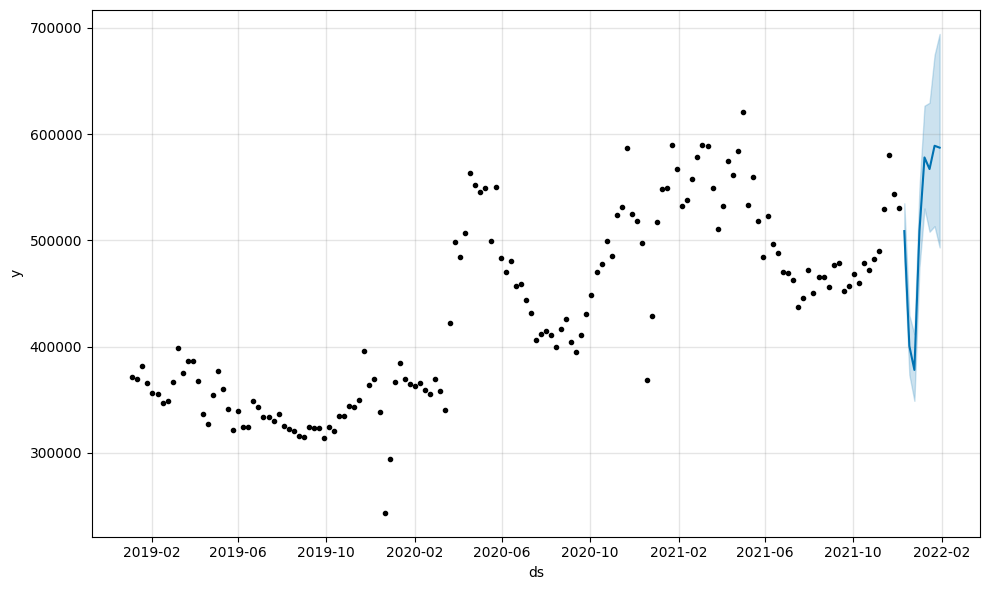

In [337]:
m.plot(pred);

In [338]:
#for self: dir(m) to list all methods of a function
fut= m.make_future_dataframe(periods=60,freq='W')
future=m.predict(fut)
forecast_final=future[['ds','trend','yhat']]

In [339]:
forecast_final

,ds,trend,yhat
0,2019-01-05,336028.629004,366654.498820
1,2019-01-12,334068.131515,369926.880198
2,2019-01-19,332107.634025,369905.825048
3,2019-01-26,330147.136536,380363.416270
4,2019-02-02,328186.639046,360744.919938
...,...,...,...
208,2022-12-25,530908.522702,386529.513418
209,2023-01-01,531200.785514,518845.039223
210,2023-01-08,531493.048325,594863.067648
211,2023-01-15,531785.311137,583844.086040


### Final Plot

[]

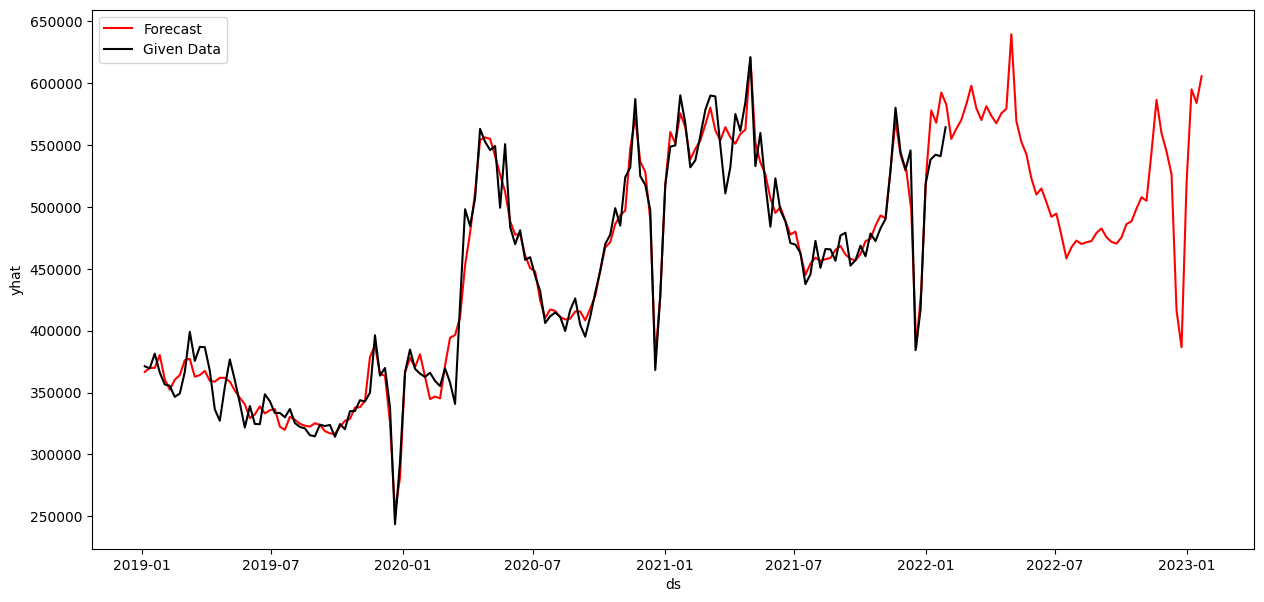

In [340]:
plt.figure(figsize=(15,7))
sns.lineplot(data=forecast_final,x='ds',y='yhat',color='red',label='Forecast')
ax=sns.lineplot(data=df1,x='ds',y='y',color='black',label='Given Data')
plt.legend(loc='upper left')
plt.plot()

## Conclusion:
* Using parameter specification, we improved the model substantially without overfitting. In this case, we improved our model by a massive 22%.
*  As per the model, we can observe a peak with highest ever recorded visitors in the month of July. 
*  We can also confirm the usual drop in the visitors around the Christmas holidays.